# Implementación WCEP para el problema de la mochila (relajado para que sea lineal)

Paper: Counterfactual explanations for linear optimization


In [2]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\PC2\OneDrive\Desktop\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB 

## Forward problem 

Inicialmente, tiene 5 variables x = (x1, x2, x3, x4, x5)

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def generate_and_solve_knapsack_forward(n_items, seed=42):
    """
    Genera y resuelve una instancia de la Mochila Continua.
    Retorna:
        - c_hat (antes v): Peso
        - a_hat: Valor
        - b_hat: valor minimo
        - x_hat, lambda_hat, mu_hat: Solución primal y dual
        - obj_val: Valor óptimo total (c * x)
    """
    np.random.seed(seed)
    
    # 1. Generar Datos
    # Notación: c (beneficio/costo), w (peso)
    a_hat = np.random.uniform(1, 10, n_items)
    c_hat = np.random.uniform(1, 25, n_items) # Antes 'values'
    
    # Capacidad ajustada 
    b_hat = np.random.uniform(5* n_items, 25 * n_items)
    
    # 2. Modelo Gurobi (FORWARD)
    m = gp.Model("Knapsack_Forward")
    m.Params.OutputFlag = 0 
    
    x = m.addVars(n_items, lb=0.0, ub=1.0, name="x")
    
    # Maximizar c^T x
    m.setObjective(gp.quicksum(c_hat[j] * x[j] for j in range(n_items)), GRB.MINIMIZE)

    # Restricción Capacidad (a^T x >= b)
    cap_constr = m.addConstr(gp.quicksum(a_hat[j] * x[j] for j in range(n_items)) >= b_hat, name="Capacity")

    m.optimize()
    
    # 3. Extraer Resultados
    x_val = np.array([x[j].X for j in range(n_items)])
    lambda_val = cap_constr.Pi  # Precio sombra de la capacidad
    
    # Cálculo de mu (Beneficio reducido / Ganancia neta)
    # KKT: mu = max(0, c - lambda*w)
    mu_val = np.minimum(0, c_hat - (lambda_val * a_hat))
    
    return c_hat, a_hat, b_hat, x_val, lambda_val, mu_val, m.ObjVal

# =========================================================
# EJECUCIÓN (SOLO FORWARD)
# =========================================================
n = 5
c_hat, a_hat, b_hat, x_hat, lam_hat, mu_hat, obj_val = generate_and_solve_knapsack_forward(n, seed=42)

print(f"=== PROBLEMA FORWARD (N={n}) ===")
print(f"Capacidad (b): {b_hat:.2f} | Costo del Espacio (Lambda): {lam_hat:.4f}")
print("-" * 85)
print(f"{'Item':<5} | {'Peso (a)':<10} | {'Valor (c)':<10} | {'Costo Espacio':<15} | {'Mu (Gain)':<15} | {'x':<5}")
print("-" * 85)

for j in range(n):
    # Costo que cobra la mochila por guardar este item
    cost_space = lam_hat * a_hat[j]
    
    # Etiquetas para entender qué pasó
    mark = ""
    if x_hat[j] < 0.001: 
        mark = " <-- NO ELEGIDO"
    elif 0.001 < x_hat[j] < 0.999: 
        mark = " <-- SPLIT (Item Marginal)"
    
    print(f"{j:<5} | {a_hat[j]:<10.2f} | {c_hat[j]:<10.2f} | {cost_space:<15.2f} | {mu_hat[j]:<15.2f} | {x_hat[j]:<5.2f}{mark}")

print("-" * 85)
print(f"VALOR ÓPTIMO TOTAL (c*x): {obj_val:.4f}")

=== PROBLEMA FORWARD (N=5) ===
Capacidad (b): 27.06 | Costo del Espacio (Lambda): 2.8714
-------------------------------------------------------------------------------------
Item  | Peso (a)   | Valor (c)  | Costo Espacio   | Mu (Gain)       | x    
-------------------------------------------------------------------------------------
0     | 4.37       | 4.74       | 12.55           | -7.81           | 1.00 
1     | 9.56       | 2.39       | 27.44           | -25.05          | 1.00 
2     | 7.59       | 21.79      | 21.79           | 0.00            | 0.89  <-- SPLIT (Item Marginal)
3     | 6.39       | 15.43      | 18.34           | -2.92           | 1.00 
4     | 2.40       | 17.99      | 6.90            | 0.00            | 0.00  <-- NO ELEGIDO
-------------------------------------------------------------------------------------
VALOR ÓPTIMO TOTAL (c*x): 41.9273


## WCEP para una instancia en particular

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time

# =========================================================
# 1. HELPER: FORWARD (MINIMIZACIÓN)
# =========================================================
def solve_forward_standard(c, a, b):
    """
    Resuelve: Min cx, s.t. ax >= b, 0 <= x <= 1
    """
    n = len(c)
    m = gp.Model("Forward_Check")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    
    # Minimizar Costo
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    # Sujeto a Beneficio Mínimo
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

def generate_and_solve_knapsack_forward(n_items, seed=42):
    np.random.seed(seed)
    a_hat = np.random.uniform(5, 15, n_items)   # Coeficiente restricción (Beneficio)
    c_hat = np.random.uniform(1, 10, n_items)   # Coeficiente objetivo (Costo)
    b_hat = np.sum(a_hat) * 0.6                 # RHS (Requerimiento)
    
    val, x_val = solve_forward_standard(c_hat, a_hat, b_hat)
    return c_hat, a_hat, b_hat, x_val, val

# =========================================================
# 2. SOLVER WCEP: EXCLUSIÓN (x=0) CON COLUMNAS (c,a)
# =========================================================
def solve_wcep_columnar(c_hat, a_hat, b_hat, target_idx, fixed_indices, mode_columns=True):
    """
    Resuelve el problema inverso para forzar x[target] = 0.
    
    mode_columns = True  -> Muta columnas (cj, aj) que no estén en fixed_indices. b fijo.
    mode_columns = False -> Muta solo b. Columnas (c,a) fijas.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Exclusion_Columnar")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2  # Habilita restricciones cuadráticas/bilineales
    model.Params.TimeLimit = 20 # Límite de tiempo
    
    # --- VARIABLES ---
    # Permitimos que c y a varíen dentro de un rango razonable (evitar 0 o infinito)
    c = model.addVars(n, lb=0.1, ub=30.0, name="c") 
    a = model.addVars(n, lb=0.1, ub=30.0, name="a")
    b = model.addVar(lb=0.0, ub=b_hat*2, name="b")
    
    # Variables duales y primales
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD ---
    if mode_columns:
        # MODO COLUMNAS: b fijo, (c,a) libres salvo fixed_indices
        model.addConstr(b == b_hat, name="Fix_b")
        
        for j in range(n):
            if j in fixed_indices:
                # La columna completa (cj, aj) es inmutable
                model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
                model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
            # Si NO está en fixed_indices, son libres
    else:
        # MODO RHS: b libre, todas las columnas fijas
        for j in range(n):
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT MINIMIZACIÓN ---
    # 1. Primal (>= b)
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    # 2. Dual (lam*a - mu <= c)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
        
    # 3. Strong Duality (Primal <= Dual para forzar igualdad)
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EXCLUSIÓN) ---
    # Forzamos que el target salga de la mochila
    model.addConstr(x[target_idx] == 0.0, name="Force_Exclusion")
    
    # --- OBJETIVO ---
    dist = 0
    if mode_columns:
        # Sumar distancias de columnas MUTABLES (cuadráticas)
        for j in range(n):
            if j not in fixed_indices:
                dist += (c[j] - c_hat[j]) * (c[j] - c_hat[j])
                dist += (a[j] - a_hat[j]) * (a[j] - a_hat[j])
    else:
        # Distancia solo de b
        dist += (b - b_hat) * (b - b_hat)

    model.setObjective(dist, GRB.MINIMIZE)
    
    # --- EJECUTAR ---
    model.optimize()
    
    if model.Status == GRB.OPTIMAL:
        return True, np.array([c[j].X for j in range(n)]), \
                     np.array([a[j].X for j in range(n)]), b.X, \
                     np.array([x[j].X for j in range(n)])
    else:
        return False, c_hat, a_hat, b_hat, np.zeros(n)

# =========================================================
# 3. EXPERIMENTO
# =========================================================
NUM_RUNS = 5
N_ITEMS = 6
FIXED_IDXS = [0, 1, 2] # Columnas H1, H2, H3 son inmutables
MODE_COLUMNS = True    # True: Variar (c,a). False: Variar b.

print(f"EXPERIMENTO WCEP: Exclusión (x=0) con Variación de Columnas")
print(f"Modo Variación Columnas: {MODE_COLUMNS} | Indices Fijos: {FIXED_IDXS}")
print("="*100)

for r in range(NUM_RUNS):
    seed = 42 + r*555
    c_hat, a_hat, b_hat, x_orig, val_orig = generate_and_solve_knapsack_forward(N_ITEMS, seed)
    
    # Buscar target para SACAR (alguien que esté dentro, x ~ 1)
    target = -1
    for j in range(N_ITEMS):
        if x_orig[j] > 0.99:
            target = j
            break
            
    if target == -1: 
        print(f"Run {r}: Ningún ítem seleccionado (Mochila vacía). Saltando.")
        continue

    # Resolver WCEP
    feasible, c_new, a_new, b_new, x_new = solve_wcep_columnar(
        c_hat, a_hat, b_hat, target, FIXED_IDXS, mode_columns=MODE_COLUMNS
    )
    
    if not feasible:
        print(f"Run {r} (Target {target}): INFACTIBLE")
        continue

    # Reporte
    print(f"\nRUN {r} | Target {target} (Exclusión: x=1 -> x=0)")
    if not MODE_COLUMNS:
         print(f"    b: {b_hat:.2f} -> {b_new:.2f}")

    print("-" * 105)
    print(f"{'Item':<4} {'St':<6} | {'c Orig':<7} {'c New':<7} {'Dc':<6} | {'a Orig':<7} {'a New':<7} {'Da':<6} | {'x Old':<5} {'x New':<5}")
    print("-" * 105)
    
    for j in range(N_ITEMS):
        is_fixed = j in FIXED_IDXS if MODE_COLUMNS else True
        state = "FIX" if is_fixed else "MUT"
        
        dc = c_new[j] - c_hat[j]
        da = a_new[j] - a_hat[j]
        
        # Formato condicional para ver cambios fácilmente
        str_dc = f"{dc:+.2f}" if abs(dc)>0.01 else " -- "
        str_da = f"{da:+.2f}" if abs(da)>0.01 else " -- "
        
        print(f"{j:<4} {state:<6} | {c_hat[j]:<7.2f} {c_new[j]:<7.2f} {str_dc:<6} | {a_hat[j]:<7.2f} {a_new[j]:<7.2f} {str_da:<6} | {x_orig[j]:<5.2f} {x_new[j]:<5.2f}")
    print("-" * 105)

EXPERIMENTO WCEP: Exclusión (x=0) con Variación de Columnas
Modo Variación Columnas: True | Indices Fijos: [0, 1, 2]
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653481
Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl

RUN 0 | Target 0 (Exclusión: x=1 -> x=0)
---------------------------------------------------------------------------------------------------------
Item St     | c Orig  c New   Dc     | a Orig  a New   Da     | x Old x New
---------------------------------------------------------------------------------------------------------
0    FIX    | 1.52    1.52     --    | 8.75    8.75     --    | 1.00  0.00 
1    FIX    | 8.80    8.80     --    | 14.51   14.51    --    | 0.56  0.00 
2    FIX    | 6.41    6.41     --    | 12.32   12.32    --    | 1.00  0.00 
3    MUT    | 7.37    2.61    -4.76  | 10.99   14.99   +4.00  | 0.00  1.00 
4    MUT    | 1.19    1.19     --    | 6.56    9.73    +3.17  | 1.00

KeyboardInterrupt: 

## WCEP gráfico 3D cambiando dimensionalidad del H y cantidad de restricciones del D

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    # RANGOS ACTUALIZADOS SEGÚN TU PEDIDO
    a = np.random.uniform(1, 10, n_items)   # Beneficios (filas A)
    c = np.random.uniform(1, 25, n_items)   # Costos (Función objetivo)
    
    # RECOMENDACIÓN PARA B:
    # Usamos un factor aleatorio entre 40% y 60% del beneficio total posible.
    # Esto asegura que el problema sea factible y no trivial.
    # Usar 25*n lo haría infactible (ya que max(a)=10).
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    # Min Costo s.a. Beneficio >= b
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP COMPLETO (Columnas + b variables)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    """
    target_indices (Eje X): Índices forzados a x=0.
    mutable_indices (Eje Y): Índices donde (c, a) pueden cambiar.
    NOTA: b siempre es mutable en esta versión.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Matrix")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120 # 2 minutos máx
    
# --- VARIABLES ---
    # RANGOS AJUSTADOS A LA GENERACIÓN DE DATOS
    # c: Generado en [1, 25] -> Limites [1.0, 25.0]
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    
    # a: Generado en [1, 10] -> Limites [1.0, 10.0]
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # b: Límite dinámico pero LÓGICO.
    # El requerimiento 'b' no puede superar físicamente la suma máxima posible de beneficios.
    # Si permitimos que 'a' llegue hasta 10.0 y hay n items:
    max_theoretical_benefit = n * 10.0 
    
    # Le damos un pequeño margen extra (1.1x) por si acaso, pero no 25x.
    # Esto ayuda al solver a podar ramas infactibles rápidamente.
    b = model.addVar(lb=0.0, ub=max_theoretical_benefit * 1.1, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD (EJE Y) ---
    # Aquí definimos qué columnas (Hj) quedan fijas.
    # b NO se fija, es libre de variar para ayudar a la factibilidad.
    
    for j in range(n):
        if j not in mutable_indices:
            # Columna Inmutable (Singleton)
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT (MINIMIZACIÓN) ---
    # 1. Primal: ax >= b
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    # 2. Dual: lam*a - mu <= c
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    # 3. Strong Duality: Primal <= Dual
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EJE X - D) ---
    # Definimos D como la intersección de hiperplanos x_j = 0
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- FUNCIÓN OBJETIVO CORREGIDA ---
    # Distancia ponderada: cambios en columnas + cambio en b
    dist = 0
    
    # 1. Distancia de columnas mutables
    for j in mutable_indices:
        dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
        
    # 2. Distancia de b (¡Ahora incluida!)
    dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: MATRIZ DE CONFUSIÓN
# =========================================================
# Configuración
N_ITEMS = 10            # Tamaño del problema
REPEATS = 5             # Runs por celda
RANGES_X = [1, 2, 3, 4] # Cantidad de Targets (x=0)
RANGES_Y = [1, 2, 3, 4] # Cantidad de Columnas Mutables

# Matrices para resultados
time_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))
feas_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))

print(f"Iniciando Experimento Grid Search...")
print(f"N={N_ITEMS} | Runs={REPEATS} | b variable: SÍ")
print("="*60)

count = 0
total_cells = len(RANGES_X) * len(RANGES_Y)

for i, num_mutable in enumerate(RANGES_Y):     # Eje Y: Mutabilidad
    for j, num_targets in enumerate(RANGES_X): # Eje X: Restricciones D
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            c_hat, a_hat, b_hat = generate_data(N_ITEMS, seed)
            
            # 1. Forward para elegir candidatos
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue # Skip si forward falló (raro)
            
            # Elegir Targets: Items que están DENTRO (x > 0.9)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            # Relleno si faltan activos (caso borde)
            if len(active_indices) < num_targets:
                rest = [k for k in range(N_ITEMS) if k not in active_indices]
                active_indices.extend(rest[:num_targets - len(active_indices)])
            
            current_targets = active_indices[:num_targets]
            
            # Elegir Mutables: Aleatorio del total
            all_idxs = list(range(N_ITEMS))
            # Usamos semilla para consistencia en la selección
            current_mutables = np.random.RandomState(seed).choice(all_idxs, num_mutable, replace=False)
            
            # 2. WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_targets, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        # Promedios
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] Mut={num_mutable} | Targ={num_targets} -> T={avg_t:.3f}s | Feas={avg_f:.1f}")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap 2D
plt.figure(figsize=(10, 8))
# Usamos annot_kws para mostrar Tiempo y Factibilidad en la misma celda
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y)):
    for j in range(len(RANGES_X)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X, yticklabels=RANGES_Y, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Cantidad de Restricciones D (x=0)")
plt.ylabel("Eje Y: Cantidad de Columnas Mutables (H)")
plt.title(f"Análisis de Sensibilidad WCEP (con b variable)")
plt.show()

# B) Gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X)), range(len(RANGES_Y)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

# Colorear por altura
from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X)))
ax.set_xticklabels(RANGES_X)
ax.set_yticks(range(len(RANGES_Y)))
ax.set_yticklabels(RANGES_Y)
ax.set_xlabel('Restricciones (Targets)')
ax.set_ylabel('Columnas Mutables')
ax.set_zlabel('Tiempo Promedio (s)')
plt.title("Impacto en Tiempo de Ejecución")
plt.show()

Iniciando Experimento Grid Search...
N=10 | Runs=5 | b variable: SÍ


KeyboardInterrupt: 

Iniciando Experimento Grid Search...
N=15 | Runs=5 | b variable: SÍ
[1/80] Mut=1 | Targ=1 -> T=0.535s | Feas=0.6
[2/80] Mut=1 | Targ=2 -> T=0.013s | Feas=0.0
[3/80] Mut=1 | Targ=3 -> T=0.008s | Feas=0.0
[4/80] Mut=1 | Targ=4 -> T=0.006s | Feas=0.0
[5/80] Mut=1 | Targ=5 -> T=0.006s | Feas=0.0
[6/80] Mut=1 | Targ=6 -> T=0.005s | Feas=0.0
[7/80] Mut=1 | Targ=7 -> T=0.006s | Feas=0.0
[8/80] Mut=1 | Targ=8 -> T=0.006s | Feas=0.0
[9/80] Mut=1 | Targ=9 -> T=0.004s | Feas=0.0
[10/80] Mut=1 | Targ=10 -> T=0.000s | Feas=0.0
[11/80] Mut=2 | Targ=1 -> T=25.058s | Feas=0.6
[12/80] Mut=2 | Targ=2 -> T=0.328s | Feas=0.4
[13/80] Mut=2 | Targ=3 -> T=0.023s | Feas=0.0
[14/80] Mut=2 | Targ=4 -> T=0.019s | Feas=0.0
[15/80] Mut=2 | Targ=5 -> T=0.016s | Feas=0.0
[16/80] Mut=2 | Targ=6 -> T=0.015s | Feas=0.0
[17/80] Mut=2 | Targ=7 -> T=0.006s | Feas=0.0
[18/80] Mut=2 | Targ=8 -> T=0.031s | Feas=0.2
[19/80] Mut=2 | Targ=9 -> T=0.004s | Feas=0.0
[20/80] Mut=2 | Targ=10 -> T=0.004s | Feas=0.0
[21/80] Mut=3 | Ta

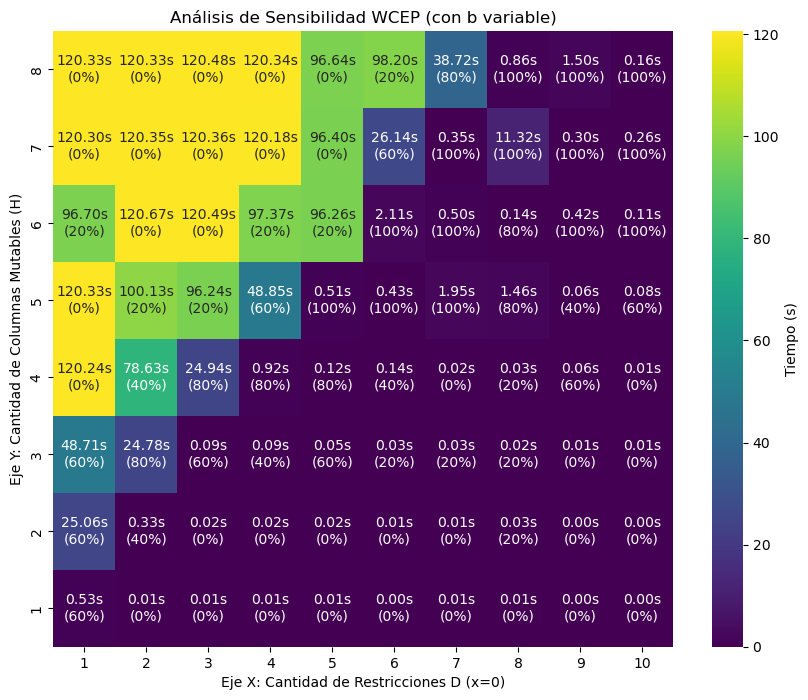

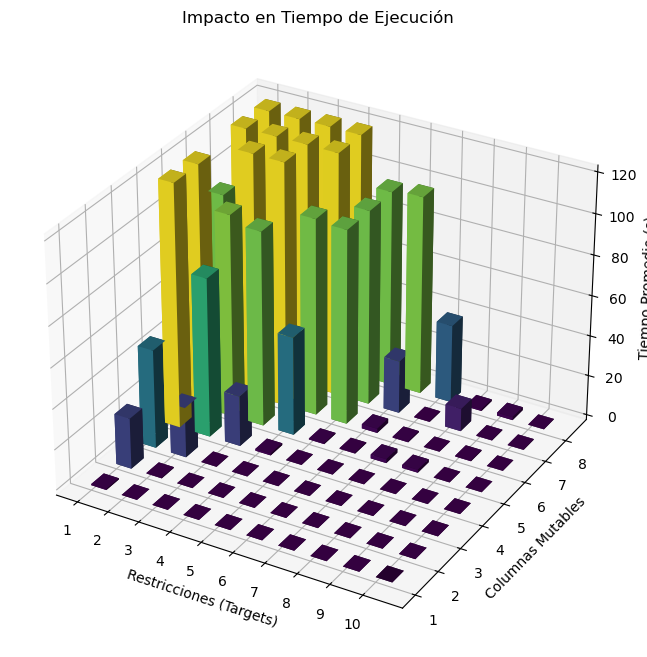

In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    # RANGOS ACTUALIZADOS SEGÚN TU PEDIDO
    a = np.random.uniform(1, 10, n_items)   # Beneficios (filas A)
    c = np.random.uniform(1, 25, n_items)   # Costos (Función objetivo)
    
    # RECOMENDACIÓN PARA B:
    # Usamos un factor aleatorio entre 40% y 60% del beneficio total posible.
    # Esto asegura que el problema sea factible y no trivial.
    # Usar 25*n lo haría infactible (ya que max(a)=10).
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    # Min Costo s.a. Beneficio >= b
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP COMPLETO (Columnas + b variables)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    """
    target_indices (Eje X): Índices forzados a x=0.
    mutable_indices (Eje Y): Índices donde (c, a) pueden cambiar.
    NOTA: b siempre es mutable en esta versión.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Matrix")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120 # 2 minutos máx
    
# --- VARIABLES ---
    # RANGOS AJUSTADOS A LA GENERACIÓN DE DATOS
    # c: Generado en [1, 25] -> Limites [1.0, 25.0]
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    
    # a: Generado en [1, 10] -> Limites [1.0, 10.0]
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # b: Límite dinámico pero LÓGICO.

    # El requerimiento 'b' no puede superar físicamente la suma máxima posible de beneficios.
    # Si permitimos que 'a' llegue hasta 10.0 y hay n items:
    max_theoretical_benefit = n * 10.0 
    b = model.addVar(lb=0.0, ub=max_theoretical_benefit, name="b")
    H_len = len(mutable_indices)
    
    model.addConstr(b <= b_hat + (H_len) * 5)
    model.addConstr(b >= b_hat - (H_len) * 5)
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD (EJE Y) ---
    # Aquí definimos qué columnas (Hj) quedan fijas.
    # b NO se fija, es libre de variar para ayudar a la factibilidad.
    
    for j in range(n):
        if j not in mutable_indices:
            # Columna Inmutable (Singleton)
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT (MINIMIZACIÓN) ---
    # 1. Primal: ax >= b
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    # 2. Dual: lam*a - mu <= c
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    # 3. Strong Duality: Primal <= Dual
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EJE X - D) ---
    # Definimos D como la intersección de hiperplanos x_j = 0
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- FUNCIÓN OBJETIVO CORREGIDA ---
    # Distancia ponderada: cambios en columnas + cambio en b
    dist = 0
    
    # 1. Distancia de columnas mutables
    for j in mutable_indices:
        dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
        
    # 2. Distancia de b (¡Ahora incluida!)
    dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: MATRIZ DE CONFUSIÓN
# =========================================================
# Configuración
N_ITEMS = 15           # Tamaño del problema
REPEATS = 5             # Runs por celda
RANGES_X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # Cantidad de Targets (x=0)
RANGES_Y = [1, 2, 3, 4, 5, 6,7,8] # Cantidad de Columnas Mutables

# Matrices para resultados
time_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))
feas_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))

print(f"Iniciando Experimento Grid Search...")
print(f"N={N_ITEMS} | Runs={REPEATS} | b variable: SÍ")
print("="*60)

count = 0
total_cells = len(RANGES_X) * len(RANGES_Y)

for i, num_mutable in enumerate(RANGES_Y):     # Eje Y: Mutabilidad
    for j, num_targets in enumerate(RANGES_X): # Eje X: Restricciones D
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            c_hat, a_hat, b_hat = generate_data(N_ITEMS, seed)
            
            # 1. Forward para elegir candidatos
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue # Skip si forward falló (raro)
            
            # Elegir Targets: Items que están DENTRO (x > 0.9)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            # Relleno si faltan activos (caso borde)
            if len(active_indices) < num_targets:
                rest = [k for k in range(N_ITEMS) if k not in active_indices]
                active_indices.extend(rest[:num_targets - len(active_indices)])
            
            current_targets = active_indices[:num_targets]
            
            # Elegir Mutables: Aleatorio del total
            all_idxs = list(range(N_ITEMS))
            # Usamos semilla para consistencia en la selección
            current_mutables = np.random.RandomState(seed).choice(all_idxs, num_mutable, replace=False)
            
            # 2. WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_targets, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        # Promedios
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] Mut={num_mutable} | Targ={num_targets} -> T={avg_t:.3f}s | Feas={avg_f:.1f}")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap 2D
plt.figure(figsize=(10, 8))
# Usamos annot_kws para mostrar Tiempo y Factibilidad en la misma celda
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y)):
    for j in range(len(RANGES_X)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X, yticklabels=RANGES_Y, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Cantidad de Restricciones D (x=0)")
plt.ylabel("Eje Y: Cantidad de Columnas Mutables (H)")
plt.title(f"Análisis de Sensibilidad WCEP (con b variable)")
plt.show()

# B) Gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X)), range(len(RANGES_Y)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

# Colorear por altura
from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X)))
ax.set_xticklabels(RANGES_X)
ax.set_yticks(range(len(RANGES_Y)))
ax.set_yticklabels(RANGES_Y)
ax.set_xlabel('Restricciones (Targets)')
ax.set_ylabel('Columnas Mutables')
ax.set_zlabel('Tiempo Promedio (s)')
plt.title("Impacto en Tiempo de Ejecución")
plt.show()

In [ ]:
for N_ITEMS in [10, 20]:  # Tamaños variados
    REPEATS = 5             # Runs por celda
    RANGES_X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # Cantidad de Targets (x=0)
    RANGES_Y = [1, 2, 3, 4, 5, 6,7,8] # Cantidad de Columnas Mutables

    # Matrices para resultados
    time_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))
    feas_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))

    print(f"Iniciando Experimento Grid Search...")
    print(f"N={N_ITEMS} | Runs={REPEATS} | b variable: SÍ")
    print("="*60)

    count = 0
    total_cells = len(RANGES_X) * len(RANGES_Y)

    for i, num_mutable in enumerate(RANGES_Y):     # Eje Y: Mutabilidad
        for j, num_targets in enumerate(RANGES_X): # Eje X: Restricciones D
            
            cell_times = []
            cell_feas = 0
            
            for r in range(REPEATS):
                seed = 42 + (i*100) + (j*10) + r
                c_hat, a_hat, b_hat = generate_data(N_ITEMS, seed)
                
                # 1. Forward para elegir candidatos
                val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
                if x_orig is None: continue # Skip si forward falló (raro)
                
                # Elegir Targets: Items que están DENTRO (x > 0.9)
                active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
                
                # Relleno si faltan activos (caso borde)
                if len(active_indices) < num_targets:
                    rest = [k for k in range(N_ITEMS) if k not in active_indices]
                    active_indices.extend(rest[:num_targets - len(active_indices)])
                
                current_targets = active_indices[:num_targets]
                
                # Elegir Mutables: Aleatorio del total
                all_idxs = list(range(N_ITEMS))
                # Usamos semilla para consistencia en la selección
                current_mutables = np.random.RandomState(seed).choice(all_idxs, num_mutable, replace=False)
                
                # 2. WCEP
                t0 = time.time()
                is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_targets, current_mutables)
                dt = time.time() - t0
                
                cell_times.append(dt)
                if is_optimal: cell_feas += 1
                
            # Promedios
            avg_t = np.mean(cell_times) if cell_times else 0
            avg_f = cell_feas / REPEATS
            
            time_matrix[i, j] = avg_t
            feas_matrix[i, j] = avg_f
            
            count += 1
            print(f"[{count}/{total_cells}] Mut={num_mutable} | Targ={num_targets} -> T={avg_t:.3f}s | Feas={avg_f:.1f}")

    # =========================================================
    # 4. VISUALIZACIÓN
    # =========================================================

    # A) Heatmap 2D
    plt.figure(figsize=(10, 8))
    # Usamos annot_kws para mostrar Tiempo y Factibilidad en la misma celda
    annot_labels = np.empty_like(time_matrix, dtype=object)
    for i in range(len(RANGES_Y)):
        for j in range(len(RANGES_X)):
            annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

    ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                    xticklabels=RANGES_X, yticklabels=RANGES_Y, cbar_kws={'label': 'Tiempo (s)'})
    ax.invert_yaxis()
    plt.xlabel("Eje X: Cantidad de Restricciones D (x=0)")
    plt.ylabel("Eje Y: Cantidad de Columnas Mutables (H)")
    plt.title(f"Análisis de Sensibilidad WCEP (con b variable) - N={N_ITEMS}")
    plt.show()

    # B) Gráfico 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_m, Y_m = np.meshgrid(range(len(RANGES_X)), range(len(RANGES_Y)))
    X_flat = X_m.flatten()
    Y_flat = Y_m.flatten()
    Z_flat = np.zeros_like(X_flat)
    DX = 0.5 * np.ones_like(Z_flat)
    DY = 0.5 * np.ones_like(Z_flat)
    DZ = time_matrix.flatten()

    # Colorear por altura
    from matplotlib import cm
    norm = plt.Normalize(DZ.min(), DZ.max())
    colors = cm.viridis(norm(DZ))

    ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

    ax.set_xticks(range(len(RANGES_X)))
    ax.set_xticklabels(RANGES_X)
    ax.set_yticks(range(len(RANGES_Y)))
    ax.set_yticklabels(RANGES_Y)
    ax.set_xlabel('Restricciones (Targets)')
    ax.set_ylabel('Columnas Mutables')
    ax.set_zlabel('Tiempo Promedio (s)')
    plt.title("Impacto en Tiempo de Ejecución")
    plt.show()

Iniciando Experimento Grid Search...
N=10 | Runs=5 | b variable: SÍ
[1/80] Mut=1 | Targ=1 -> T=0.071s | Feas=0.6
[2/80] Mut=1 | Targ=2 -> T=0.047s | Feas=0.2
[3/80] Mut=1 | Targ=3 -> T=0.007s | Feas=0.0
[4/80] Mut=1 | Targ=4 -> T=0.008s | Feas=0.0
[5/80] Mut=1 | Targ=5 -> T=0.168s | Feas=0.0
[6/80] Mut=1 | Targ=6 -> T=0.003s | Feas=0.0
[7/80] Mut=1 | Targ=7 -> T=0.002s | Feas=0.0
[8/80] Mut=1 | Targ=8 -> T=0.003s | Feas=0.0
[9/80] Mut=1 | Targ=9 -> T=0.003s | Feas=0.0
[10/80] Mut=1 | Targ=10 -> T=0.000s | Feas=0.0
[11/80] Mut=2 | Targ=1 -> T=27.698s | Feas=0.8
[12/80] Mut=2 | Targ=2 -> T=1.376s | Feas=1.0
[13/80] Mut=2 | Targ=3 -> T=0.074s | Feas=0.2
[14/80] Mut=2 | Targ=4 -> T=0.070s | Feas=0.4
[15/80] Mut=2 | Targ=5 -> T=0.016s | Feas=0.0
[16/80] Mut=2 | Targ=6 -> T=0.012s | Feas=0.0
[17/80] Mut=2 | Targ=7 -> T=0.003s | Feas=0.0
[18/80] Mut=2 | Targ=8 -> T=0.019s | Feas=0.2
[19/80] Mut=2 | Targ=9 -> T=0.003s | Feas=0.0
[20/80] Mut=2 | Targ=10 -> T=0.001s | Feas=0.0
[21/80] Mut=3 | Ta

# Comparando la dimensionalidad del H contra la dimensionalidad del D

Iniciando Estudio de Escalabilidad...
Eje X (N): [10, 14, 16, 18]
Eje Y (Mutables): [1, 2, 3, 4]
D constante: Excluir 1 ítem.
[1/16] N=10 | Mut=1 -> T=0.050s
[2/16] N=14 | Mut=1 -> T=0.017s
[3/16] N=16 | Mut=1 -> T=0.032s
[4/16] N=18 | Mut=1 -> T=0.019s
[5/16] N=10 | Mut=2 -> T=0.617s
[6/16] N=14 | Mut=2 -> T=0.349s
[7/16] N=16 | Mut=2 -> T=0.321s
[8/16] N=18 | Mut=2 -> T=0.885s
[9/16] N=10 | Mut=3 -> T=0.374s
[10/16] N=14 | Mut=3 -> T=0.382s
[11/16] N=16 | Mut=3 -> T=3.970s
[12/16] N=18 | Mut=3 -> T=12.190s
[13/16] N=10 | Mut=4 -> T=6.898s
[14/16] N=14 | Mut=4 -> T=6.584s
[15/16] N=16 | Mut=4 -> T=25.779s
[16/16] N=18 | Mut=4 -> T=79.887s


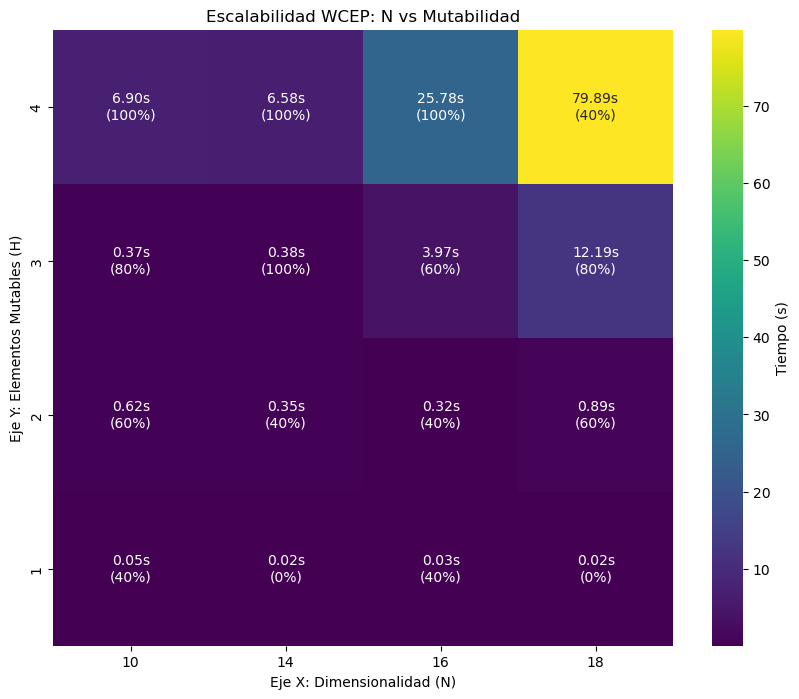

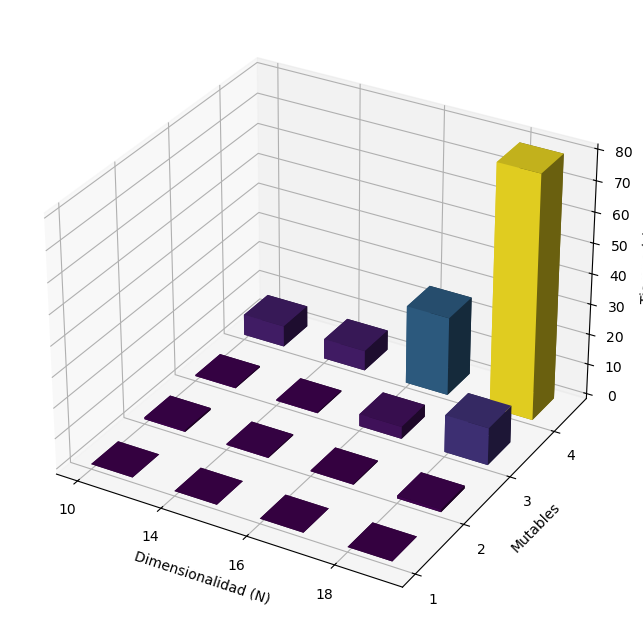

In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN Y FORWARD (ADAPTABLE A N)
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    
    # b proporcional al tamaño N para mantener consistencia
    # (aprox 50% de la capacidad teórica promedio)
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP ROBUSTO (Duales Acotados + b mutable)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    n = len(c_hat)
    model = gp.Model("WCEP_Scalability")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # --- VARIABLES ---
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # Límite físico de b depende de N (n * max_a)
    max_physical_b = n * 10.0
    b = model.addVar(lb=0.0, ub=max_physical_b, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    
    # Duales acotados para estabilidad numérica
    lam = model.addVar(lb=0.0, ub=1000.0, name="lambda")
    mu = model.addVars(n, lb=0.0, ub=1000.0, name="mu")
    
    # --- INMUTABILIDAD ---
    # Índice n representa a 'b'
    b_is_mutable = (n in mutable_indices)
    
    if not b_is_mutable:
        model.addConstr(b == b_hat)
    
    for j in range(n):
        if j not in mutable_indices:
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (D FIJO: Excluir Target) ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- OBJETIVO ---
    dist = 0
    for j in range(n):
        if j in mutable_indices:
            dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
    if b_is_mutable:
        dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: ESCALABILIDAD (N vs Mutabilidad)
# =========================================================
# EJE X: Dimensionalidad N
RANGES_X_N = [10, 14, 16, 18] 

# EJE Y: Cantidad de Mutables
RANGES_Y_MUT = [1, 2, 3, 4]

REPEATS = 5
FIXED_TARGET_COUNT = 1  # Siempre excluimos 1 ítem (D constante)

time_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))
feas_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))

print(f"Iniciando Estudio de Escalabilidad...")
print(f"Eje X (N): {RANGES_X_N}")
print(f"Eje Y (Mutables): {RANGES_Y_MUT}")
print(f"D constante: Excluir {FIXED_TARGET_COUNT} ítem.")
print("="*60)

count = 0
total_cells = len(RANGES_X_N) * len(RANGES_Y_MUT)

for i, num_mutable in enumerate(RANGES_Y_MUT):     # Filas: Mutabilidad
    for j, n_dim in enumerate(RANGES_X_N):         # Columnas: Tamaño N
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            
            # 1. Generar Datos con tamaño n_dim
            c_hat, a_hat, b_hat = generate_data(n_dim, seed)
            
            # Forward
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue
            
            # 2. Seleccionar 1 Target Fijo (D constante)
            # Buscamos el primer ítem activo para sacarlo
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            if not active_indices:
                # Si la mochila está vacía, no hay a quien sacar. 
                # Salto técnico (consideramos tiempo 0, o "factible trivial")
                continue
                
            current_target = [active_indices[0]] # Siempre tamaño 1
            
            # 3. Seleccionar Mutables (Pool size depende de n_dim)
            # Pool = [0...n-1] + [n] (donde n es b)
            pool_size = n_dim + 1
            pool_candidates = list(range(pool_size))
            
            # Cuidado: Si n=2, pool=3 (0,1,b). No podemos pedir 4 mutables.
            # Ajustamos al máximo posible físico.
            actual_k = min(num_mutable, pool_size)
            
            current_mutables = np.random.RandomState(seed).choice(pool_candidates, actual_k, replace=False)
            
            # WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_target, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS if cell_times else 0
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] N={n_dim} | Mut={num_mutable} -> T={avg_t:.3f}s")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap
plt.figure(figsize=(10, 8))
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y_MUT)):
    for j in range(len(RANGES_X_N)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X_N, yticklabels=RANGES_Y_MUT, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Dimensionalidad (N)")
plt.ylabel("Eje Y: Elementos Mutables (H)")
plt.title(f"Escalabilidad WCEP: N vs Mutabilidad")
plt.show()

# B) 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X_N)), range(len(RANGES_Y_MUT)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X_N)))
ax.set_xticklabels(RANGES_X_N)
ax.set_yticks(range(len(RANGES_Y_MUT)))
ax.set_yticklabels(RANGES_Y_MUT)    
ax.set_xlabel('Dimensionalidad (N)')
ax.set_ylabel('Mutables')
ax.set_zlabel('Tiempo (s)')
plt.show()

Iniciando Estudio de Escalabilidad con SANITY CHECK...
Eje X (N): [10, 12, 14, 16]
Eje Y (Mutables): [1, 2, 3, 4]
[1/16] N=10 | Mut=1 -> T=0.054s | Verified=40%
[2/16] N=12 | Mut=1 -> T=0.041s | Verified=20%
[3/16] N=14 | Mut=1 -> T=0.075s | Verified=20%
[4/16] N=16 | Mut=1 -> T=0.040s | Verified=0%
[5/16] N=10 | Mut=2 -> T=0.818s | Verified=20%
[6/16] N=12 | Mut=2 -> T=0.154s | Verified=20%
[7/16] N=14 | Mut=2 -> T=1.757s | Verified=20%
[8/16] N=16 | Mut=2 -> T=0.254s | Verified=0%
[9/16] N=10 | Mut=3 -> T=0.662s | Verified=40%
[10/16] N=12 | Mut=3 -> T=25.705s | Verified=20%
[11/16] N=14 | Mut=3 -> T=35.669s | Verified=0%
[12/16] N=16 | Mut=3 -> T=0.533s | Verified=40%
[13/16] N=10 | Mut=4 -> T=4.908s | Verified=40%
[14/16] N=12 | Mut=4 -> T=1.848s | Verified=20%
[15/16] N=14 | Mut=4 -> T=12.682s | Verified=40%
[16/16] N=16 | Mut=4 -> T=10.626s | Verified=0%


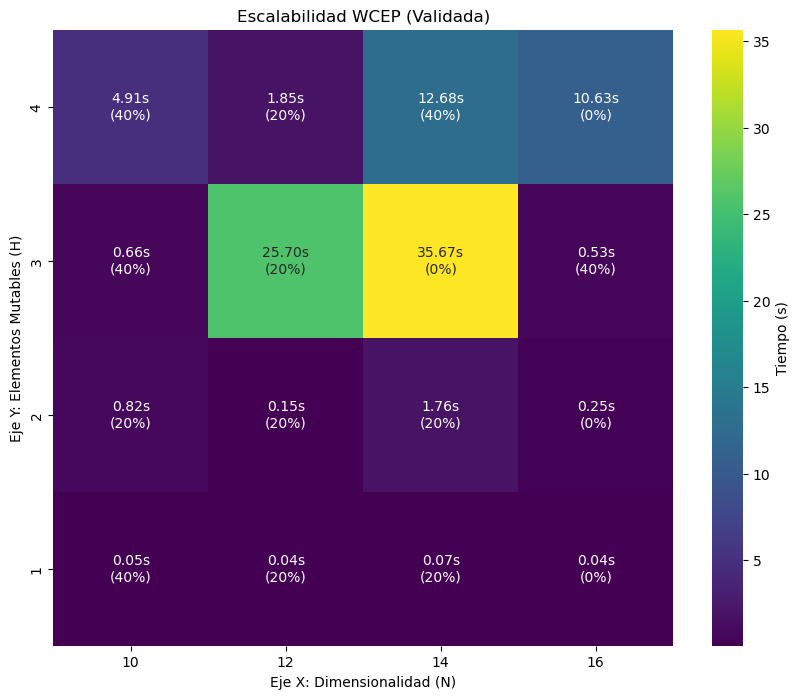

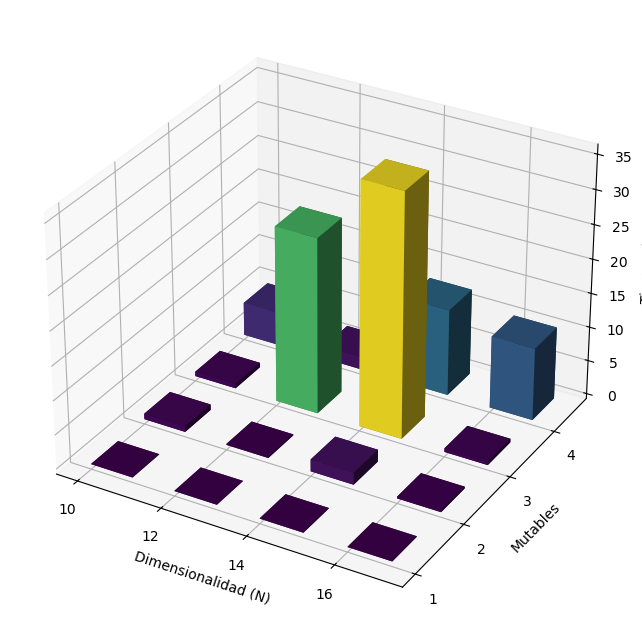

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN Y FORWARD (ADAPTABLE A N)
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    
    # b proporcional al tamaño N
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP ROBUSTO (Retorna nuevos parámetros)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    n = len(c_hat)
    model = gp.Model("WCEP_Scalability")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # --- VARIABLES ---
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    max_physical_b = n * 10.0
    b = model.addVar(lb=0.0, ub=max_physical_b, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, ub=1000.0, name="lambda")
    mu = model.addVars(n, lb=0.0, ub=1000.0, name="mu")
    
    # --- INMUTABILIDAD ---
    b_is_mutable = (n in mutable_indices)
    
    if not b_is_mutable:
        model.addConstr(b == b_hat)
    
    for j in range(n):
        if j not in mutable_indices:
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- OBJETIVO ---
    dist = 0
    for j in range(n):
        if j in mutable_indices:
            dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
    if b_is_mutable:
        dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    # RETORNO CON DATOS PARA SANITY CHECK
    if model.Status == GRB.OPTIMAL:
        c_new = np.array([c[j].X for j in range(n)])
        a_new = np.array([a[j].X for j in range(n)])
        b_new = b.X
        return True, c_new, a_new, b_new
    else:
        return False, None, None, None

# =========================================================
# 3. EXPERIMENTO: ESCALABILIDAD (CON SANITY CHECK)
# =========================================================
# EJE X: Dimensionalidad N
RANGES_X_N = [10, 12, 14, 16] 

# EJE Y: Cantidad de Mutables
RANGES_Y_MUT = [1, 2, 3, 4]

REPEATS = 5
FIXED_TARGET_COUNT = 2 

time_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))
feas_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))

print(f"Iniciando Estudio de Escalabilidad con SANITY CHECK...")
print(f"Eje X (N): {RANGES_X_N}")
print(f"Eje Y (Mutables): {RANGES_Y_MUT}")
print("="*60)

count = 0
total_cells = len(RANGES_X_N) * len(RANGES_Y_MUT)

for i, num_mutable in enumerate(RANGES_Y_MUT):     # Filas
    for j, n_dim in enumerate(RANGES_X_N):         # Columnas
        
        cell_times = []
        cell_feas_verified = 0 # Contador de casos VERIFICADOS
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            
            # 1. Generar
            c_hat, a_hat, b_hat = generate_data(n_dim, seed)
            
            # Forward Original
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue
            
            # Target (Excluir ítem activo)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            if not active_indices: continue
            current_target = [active_indices[0]] 
            target_idx = current_target[0]
            
            # Pool de Mutables
            pool_size = n_dim + 1
            pool_candidates = list(range(pool_size))
            actual_k = min(num_mutable, pool_size)
            current_mutables = np.random.RandomState(seed).choice(pool_candidates, actual_k, replace=False)
            
            # 2. WCEP Solver
            t0 = time.time()
            is_optimal, c_new, a_new, b_new = solve_wcep_matrix(c_hat, a_hat, b_hat, current_target, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            
            if is_optimal:
                # =========================================================
                # 3. SANITY CHECK (VERIFICACIÓN)
                # =========================================================
                # Resolvemos el problema forward "limpio" con los nuevos parámetros
                val_check, x_check = solve_forward_standard(c_new, a_new, b_new)
                
                if x_check is not None:
                    # Verificamos si el target efectivamente salió (x < epsilon)
                    # Usamos 1e-4 como tolerancia
                    if x_check[target_idx] < 1e-4:
                        cell_feas_verified += 1
                    else:
                        # Si entra aquí, WCEP mintió o hubo error numérico
                        # print(f"Check Fail: Run {r}, Target era {target_idx}, pero quedó en {x_check[target_idx]:.2f}")
                        pass
                else:
                    # Si el nuevo problema es infactible (raro con b variable, pero posible)
                    pass

        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas_verified / REPEATS if cell_times else 0
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] N={n_dim} | Mut={num_mutable} -> T={avg_t:.3f}s | Verified={avg_f*100:.0f}%")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap
plt.figure(figsize=(10, 8))
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y_MUT)):
    for j in range(len(RANGES_X_N)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X_N, yticklabels=RANGES_Y_MUT, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Dimensionalidad (N)")
plt.ylabel("Eje Y: Elementos Mutables (H)")
plt.title(f"Escalabilidad WCEP (Validada)")
plt.show()

# B) 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X_N)), range(len(RANGES_Y_MUT)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X_N)))
ax.set_xticklabels(RANGES_X_N)
ax.set_yticks(range(len(RANGES_Y_MUT)))
ax.set_yticklabels(RANGES_Y_MUT)
ax.set_xlabel('Dimensionalidad (N)')
ax.set_ylabel('Mutables')
ax.set_zlabel('Tiempo (s)')
plt.show()

# Ver qué es lo que pasa cuando se varia SOLO A, SOLO b, SOLO c, y comparar los tiempos de ejecución a medida que aumenta el x

# Ver cómo se ven afectados los tiempos de ejecución para diferentes x's si solo variamos (c, A) o solo b, y luego resolver

# Ver qué es lo que pasa cuando se varia SOLO A, SOLO b, SOLO c, y comparar los tiempos de ejecución a medida que aumenta el x (en otro bloque, por si es que se llegasen a trasponer)

## La idea, además, es comparar los tiempos de ejecución y el valor de la función objetivo promedio entre estos casos con el caso original.

### Solo varía A o b o c

Button(button_style='danger', description='STOP', style=ButtonStyle())


>>> Corriendo Experimento Matricial: Variando SOLO A <<<
Set parameter Username
Set parameter LicenseID to value 2748035
Academic license - for non-commercial use only - expires 2026-12-01
[A] Mut=2, N=14 -> 0.39s
[A] Mut=2, N=16 -> 0.89s
[A] Mut=2, N=18 -> 1.02s
[A] Mut=2, N=20 -> 0.62s
[A] Mut=3, N=14 -> 1.04s
[A] Mut=3, N=16 -> 0.99s
[A] Mut=3, N=18 -> 0.76s
[A] Mut=3, N=20 -> 7.39s
[A] Mut=4, N=14 -> 0.53s
[A] Mut=4, N=16 -> 0.56s
[A] Mut=4, N=18 -> 0.36s
[A] Mut=4, N=20 -> 3.68s
[A] Mut=5, N=14 -> 1.81s
[A] Mut=5, N=16 -> 1.42s
[A] Mut=5, N=18 -> 3.05s
[A] Mut=5, N=20 -> 6.61s

>>> Corriendo Experimento Matricial: Variando SOLO C <<<
[C] Mut=2, N=14 -> 0.03s
[C] Mut=2, N=16 -> 0.06s
[C] Mut=2, N=18 -> 0.06s
[C] Mut=2, N=20 -> 0.03s
[C] Mut=3, N=14 -> 0.08s
[C] Mut=3, N=16 -> 0.30s
[C] Mut=3, N=18 -> 0.09s
[C] Mut=3, N=20 -> 0.17s
[C] Mut=4, N=14 -> 0.47s
[C] Mut=4, N=16 -> 32.47s
[C] Mut=4, N=18 -> 5.01s
[C] Mut=4, N=20 -> 6.15s
[C] Mut=5, N=14 -> 28.02s
[C] Mut=5, N=16 -> 59.69s

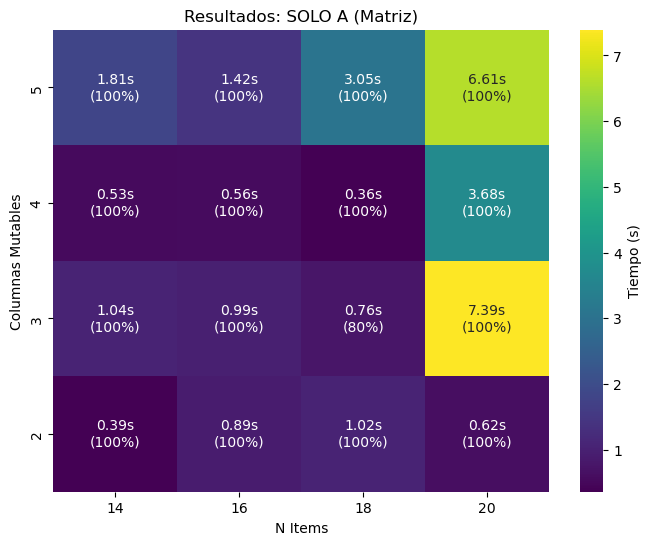

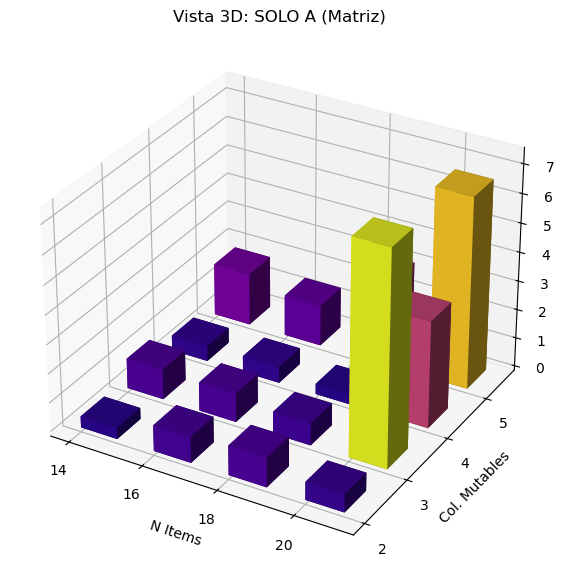

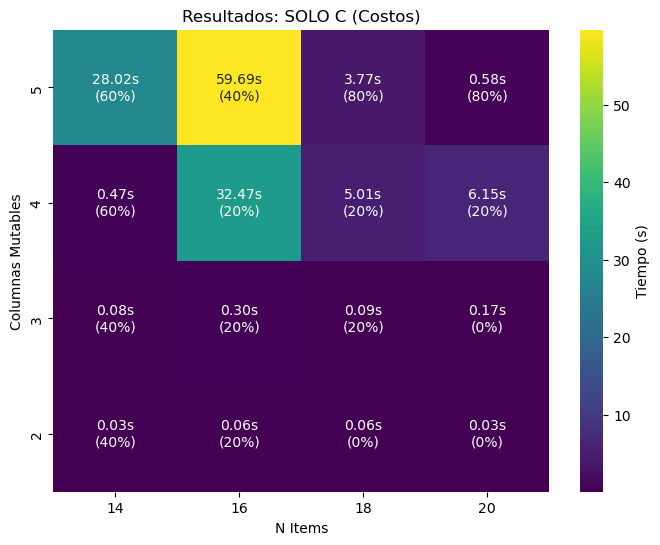

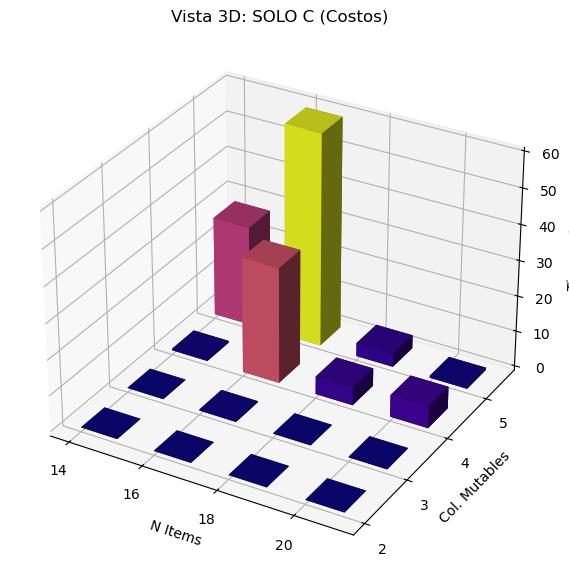

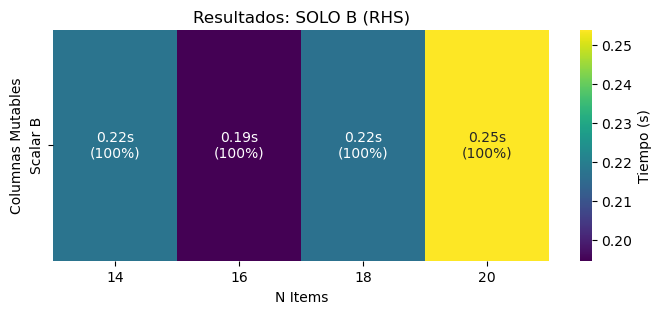

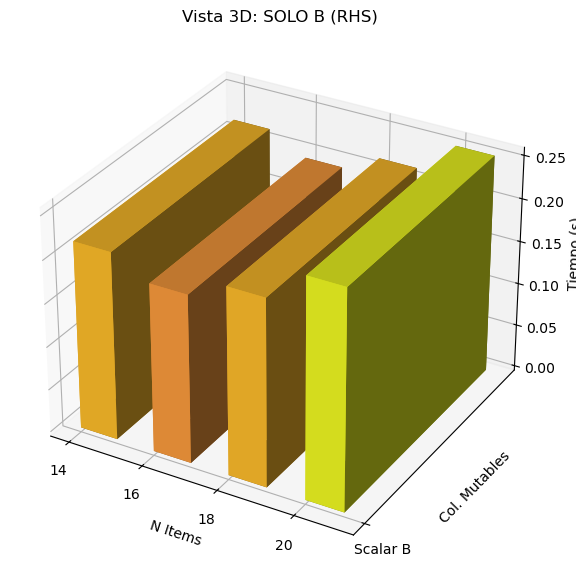

In [1]:
# boton de panico
import ipywidgets as widgets
from IPython.display import display

# Flag global de parada
stop_execution = False

def stop_callback(b):
    global stop_execution
    stop_execution = True
    print("⛔ Ejecución detenida por el usuario.")

stop_button = widgets.Button(
    description="STOP",
    button_style="danger"
)

stop_button.on_click(stop_callback)
display(stop_button)

#-------------------------

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP FLEXIBLE
# =========================================================
def solve_wcep_flexible(c_hat, a_hat, b_hat, target_indices, mutable_indices, mode='A'): 
    n = len(c_hat)
    model = gp.Model("WCEP_Flexible")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # Límites amplios
    c = model.addVars(n, lb=1, ub=1000, name="c") 
    a = model.addVars(n, lb=1, ub=50.0, name="a")
    max_theoretical_benefit = n * 50.0 
    b = model.addVar(lb=0.0, ub=max_theoretical_benefit, name="b")

    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")

    epsilon = 1e-5

    # --- CONFIGURACIÓN DE INMUTABILIDAD ---
    if mode == 'A':
        model.addConstr(b >= b_hat - epsilon)
        model.addConstr(b <= b_hat + epsilon)
        for j in range(n):
            model.addConstr(c[j] >= c_hat[j] - epsilon)
            model.addConstr(c[j] <= c_hat[j] + epsilon)
            if j not in mutable_indices:
                model.addConstr(a[j] >= a_hat[j] - epsilon)
                model.addConstr(a[j] <= a_hat[j] + epsilon)

    elif mode == 'C':
        model.addConstr(b >= b_hat - epsilon)
        model.addConstr(b <= b_hat + epsilon)
        for j in range(n):
            model.addConstr(a[j] >= a_hat[j] - epsilon)
            model.addConstr(a[j] <= a_hat[j] + epsilon)
            if j not in mutable_indices:
                model.addConstr(c[j] >= c_hat[j] - epsilon)
                model.addConstr(c[j] <= c_hat[j] + epsilon)

    elif mode == 'B':
        # Variamos b libremente. A y C fijos completamente.
        model.addConstr(b <= b_hat + 100)
        model.addConstr(b >= max(0, b_hat - 100))
        for j in range(n):
            model.addConstr(a[j] >= a_hat[j] - epsilon)
            model.addConstr(a[j] <= a_hat[j] + epsilon)
            model.addConstr(c[j] >= c_hat[j] - epsilon)
            model.addConstr(c[j] <= c_hat[j] + epsilon)

    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)

    # --- CONTRAFACTUAL (TARGETS) ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)

    # --- OBJETIVO ---
    dist = 0
    if mode == 'A':
        for j in mutable_indices: dist += (a[j] - a_hat[j])**2
    elif mode == 'C':
        for j in mutable_indices: dist += (c[j] - c_hat[j])**2
    elif mode == 'B':
        dist += (b - b_hat)**2

    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EJECUCIÓN DE EXPERIMENTOS
# =========================================================

RANGES_N_ITEMS = [14, 16, 18, 20]
RANGES_MUTABLES = [2, 3, 4, 5] # Para A y C
REPEATS = 5

def run_experiment_matrix(mode_label):
    print(f"\n>>> Corriendo Experimento Matricial: Variando SOLO {mode_label} <<<")
    # Matriz completa (Filas x Columnas)
    t_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    f_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    
    for i, num_mutable in enumerate(RANGES_MUTABLES):
        for j, n_items in enumerate(RANGES_N_ITEMS):
            times, feas = [], 0
            
            for r in range(REPEATS):
                seed = 2000 + (i*100) + (j*10) + r
                c_h, a_h, b_h = generate_data(n_items, seed)
                _, x_orig = solve_forward_standard(c_h, a_h, b_h)
                if x_orig is None: continue
                
                actives = [k for k, v in enumerate(x_orig) if v > 0.9]
                if not actives: continue
                targets = [actives[0]] # 1 Target fijo
                
                all_idxs = list(range(n_items))
                curr_mut = min(num_mutable, n_items)
                mutables = np.random.RandomState(seed).choice(all_idxs, curr_mut, replace=False)
                
                t0 = time.time()
                is_opt = solve_wcep_flexible(c_h, a_h, b_h, targets, mutables, mode=mode_label)
                times.append(time.time() - t0)
                if is_opt: feas += 1
            
            t_mat[i, j] = np.mean(times) if times else 0
            f_mat[i, j] = feas / REPEATS
            print(f"[{mode_label}] Mut={num_mutable}, N={n_items} -> {t_mat[i,j]:.2f}s")
    return t_mat, f_mat

def run_experiment_b():
    print(f"\n>>> Corriendo Experimento Escalar: Variando SOLO B <<<")
    # Para B, solo necesitamos 1 fila de resultados (1 x N_ITEMS)
    # porque "Mutables=1" es lo mismo que "Mutables=4" (solo existe b).
    t_mat = np.zeros((1, len(RANGES_N_ITEMS)))
    f_mat = np.zeros((1, len(RANGES_N_ITEMS)))
    
    for j, n_items in enumerate(RANGES_N_ITEMS):
        times, feas = [], 0
        
        for r in range(REPEATS):
            seed = 3000 + (j*10) + r
            c_h, a_h, b_h = generate_data(n_items, seed)
            _, x_orig = solve_forward_standard(c_h, a_h, b_h)
            if x_orig is None: continue
            
            actives = [k for k, v in enumerate(x_orig) if v > 0.9]
            if not actives: continue
            targets = [actives[0]]
            
            mutables = [] # Dummy
            
            t0 = time.time()
            is_opt = solve_wcep_flexible(c_h, a_h, b_h, targets, mutables, mode='B')
            times.append(time.time() - t0)
            if is_opt: feas += 1
        
        t_mat[0, j] = np.mean(times) if times else 0
        f_mat[0, j] = feas / REPEATS
        print(f"[B] N={n_items} -> {t_mat[0,j]:.2f}s")
    return t_mat, f_mat

# --- Ejecución ---
time_A, feas_A = run_experiment_matrix('A')
time_C, feas_C = run_experiment_matrix('C')
time_B, feas_B = run_experiment_b() # Matriz 1xN

# =========================================================
# 4. PLOTTING UNIFICADO
# =========================================================
def plot_matrix(time_mat, feas_mat, mode_name, y_labels=None):
    if y_labels is None:
        y_labels = RANGES_MUTABLES
        
    # --- 1. Heatmap ---
    plt.figure(figsize=(8, 6 if len(y_labels) > 1 else 3)) # Altura dinámica
    annot = np.empty_like(time_mat, dtype=object)
    
    rows, cols = time_mat.shape
    for i in range(rows):
        for j in range(cols):
            annot[i, j] = f"{time_mat[i, j]:.2f}s\n({feas_mat[i, j]*100:.0f}%)"
            
    sns.heatmap(time_mat, annot=annot, fmt="", cmap="viridis",
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, 
                cbar_kws={'label': 'Tiempo (s)'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables")
    plt.title(f"Resultados: SOLO {mode_name}")
    plt.show()

    # --- 2. Gráfico 3D ---
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    _x = np.arange(cols)
    _y = np.arange(rows)
    X_m, Y_m = np.meshgrid(_x, _y)
    
    x_flat = X_m.flatten()
    y_flat = Y_m.flatten()
    z_flat = np.zeros_like(x_flat)
    dx = 0.5 * np.ones_like(z_flat)
    dy = 0.5 * np.ones_like(z_flat)
    dz = time_mat.flatten()
    
    from matplotlib import cm
    norm = plt.Normalize(0, max(np.max(dz), 0.1)) 
    colors = cm.plasma(norm(dz))
    
    ax.bar3d(x_flat, y_flat, z_flat, dx, dy, dz, color=colors, shade=True)
    
    ax.set_xticks(_x)
    ax.set_xticklabels(RANGES_N_ITEMS)
    ax.set_yticks(_y)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('N Items')
    ax.set_ylabel('Col. Mutables')
    ax.set_zlabel('Tiempo (s)')
    plt.title(f"Vista 3D: SOLO {mode_name}")
    plt.show()

# --- Mostrar ---
plot_matrix(time_A, feas_A, "A (Matriz)")
plot_matrix(time_C, feas_C, "C (Costos)")
# Para B pasamos una etiqueta especial y matriz de 1 fila
plot_matrix(time_B, feas_B, "B (RHS)", y_labels=["Scalar B"])


>>> Corriendo Experimento Matricial: Variando SOLO A <<<
Set parameter Username
Set parameter LicenseID to value 2748035
Academic license - for non-commercial use only - expires 2026-12-01
[A] Mut=2, N=14 -> T=0.29s, Obj=435.35
[A] Mut=2, N=16 -> T=0.72s, Obj=181.37
[A] Mut=2, N=18 -> T=1.24s, Obj=735.98
[A] Mut=2, N=20 -> T=1.50s, Obj=512.32
[A] Mut=3, N=14 -> T=0.58s, Obj=339.47
[A] Mut=3, N=16 -> T=0.54s, Obj=736.04
[A] Mut=3, N=18 -> T=0.32s, Obj=249.31
[A] Mut=3, N=20 -> T=5.37s, Obj=706.85
[A] Mut=4, N=14 -> T=0.72s, Obj=111.95
[A] Mut=4, N=16 -> T=0.72s, Obj=101.45
[A] Mut=4, N=18 -> T=1.35s, Obj=75.79
[A] Mut=4, N=20 -> T=5.16s, Obj=115.23
[A] Mut=5, N=14 -> T=29.21s, Obj=90.20
[A] Mut=5, N=16 -> T=2.50s, Obj=30.00
[A] Mut=5, N=18 -> T=6.77s, Obj=34.82
[A] Mut=5, N=20 -> T=2.72s, Obj=308.04

>>> Corriendo Experimento Matricial: Variando SOLO C <<<
[C] Mut=2, N=14 -> T=0.07s, Obj=91.51
[C] Mut=2, N=16 -> T=0.11s, Obj=57.01
[C] Mut=2, N=18 -> T=0.20s, Obj=0.00
[C] Mut=2, N=20 ->

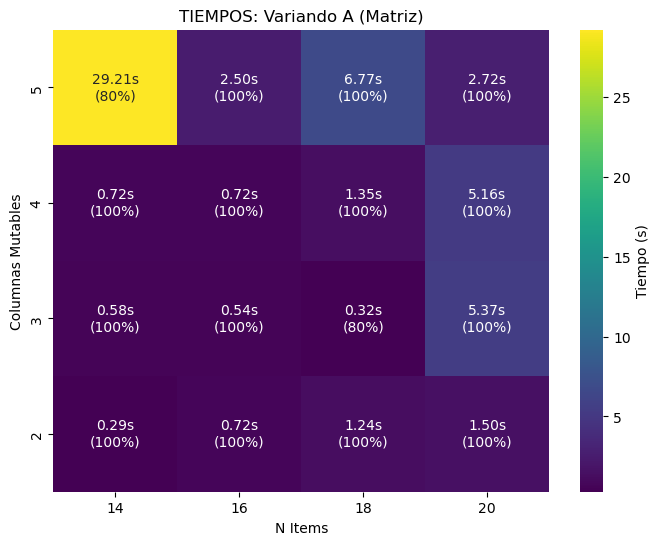

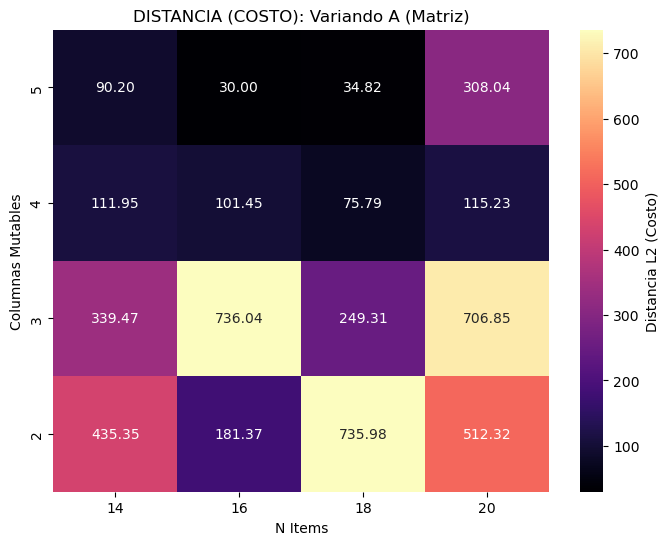

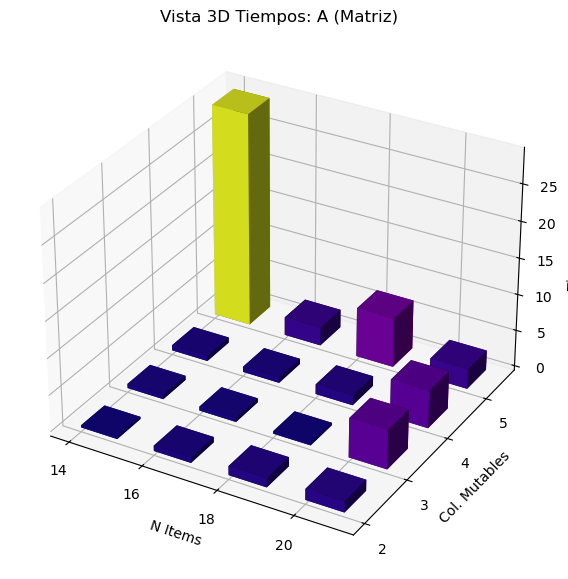

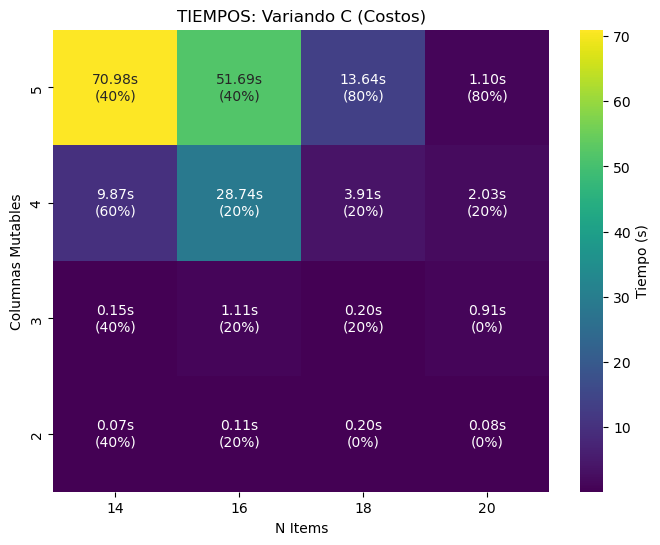

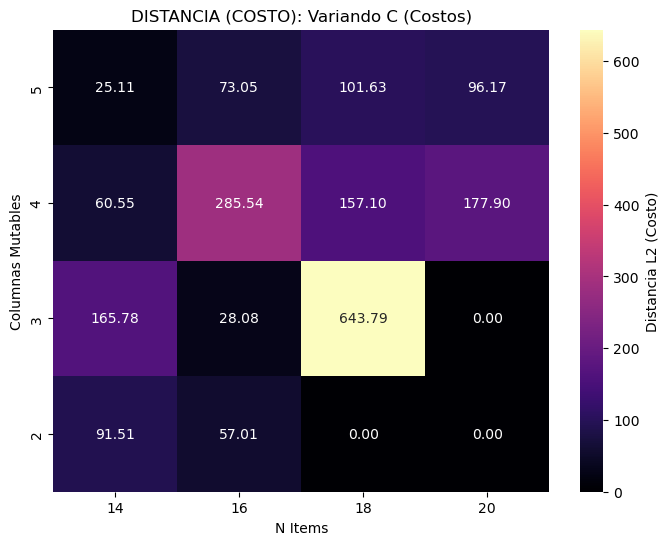

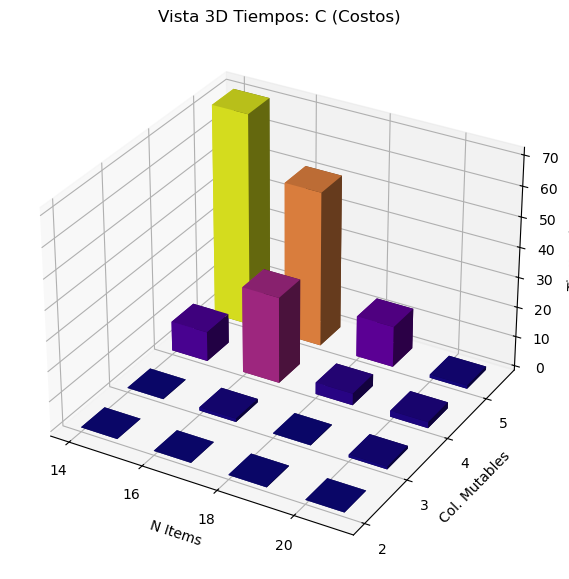

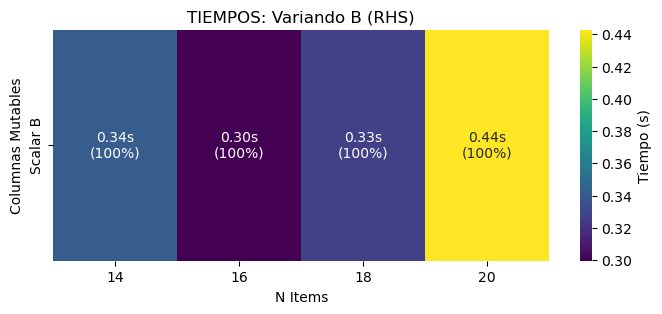

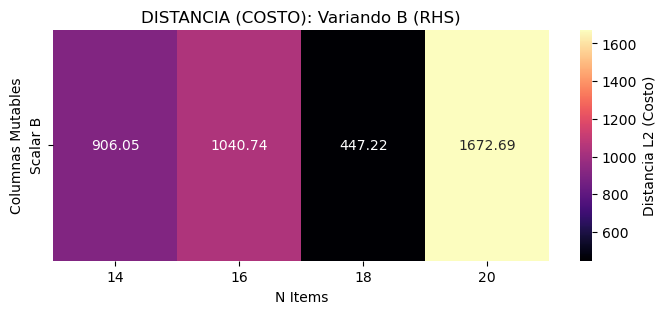

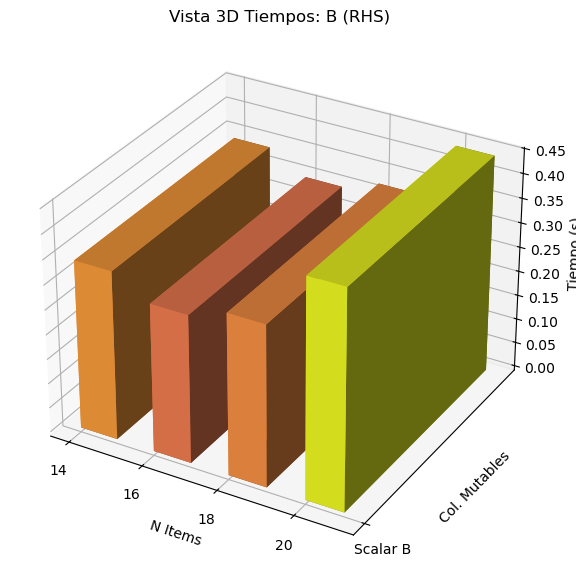

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP FLEXIBLE (Retorna ObjVal)
# =========================================================
def solve_wcep_flexible(c_hat, a_hat, b_hat, target_indices, mutable_indices, mode='A'): 
    n = len(c_hat)
    model = gp.Model("WCEP_Flexible")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # Límites amplios
    c = model.addVars(n, lb=0.1, ub=1000.0, name="c") 
    a = model.addVars(n, lb=0.01, ub=50.0, name="a")
    max_theoretical_benefit = n * 50.0 
    b = model.addVar(lb=0.0, ub=max_theoretical_benefit, name="b")

    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")

    epsilon = 1e-5

    # --- INMUTABILIDAD ---
    if mode == 'A':
        model.addConstr(b >= b_hat - epsilon)
        model.addConstr(b <= b_hat + epsilon)
        for j in range(n):
            model.addConstr(c[j] >= c_hat[j] - epsilon)
            model.addConstr(c[j] <= c_hat[j] + epsilon)
            if j not in mutable_indices:
                model.addConstr(a[j] >= a_hat[j] - epsilon)
                model.addConstr(a[j] <= a_hat[j] + epsilon)

    elif mode == 'C':
        model.addConstr(b >= b_hat - epsilon)
        model.addConstr(b <= b_hat + epsilon)
        for j in range(n):
            model.addConstr(a[j] >= a_hat[j] - epsilon)
            model.addConstr(a[j] <= a_hat[j] + epsilon)
            if j not in mutable_indices:
                model.addConstr(c[j] >= c_hat[j] - epsilon)
                model.addConstr(c[j] <= c_hat[j] + epsilon)

    elif mode == 'B':
        model.addConstr(b <= b_hat + 100)
        model.addConstr(b >= max(0, b_hat - 100))
        for j in range(n):
            model.addConstr(a[j] >= a_hat[j] - epsilon)
            model.addConstr(a[j] <= a_hat[j] + epsilon)
            model.addConstr(c[j] >= c_hat[j] - epsilon)
            model.addConstr(c[j] <= c_hat[j] + epsilon)

    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)

    # --- CONTRAFACTUAL ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)

    # --- OBJETIVO ---
    dist = 0
    if mode == 'A':
        for j in mutable_indices: dist += (a[j] - a_hat[j])**2
    elif mode == 'C':
        for j in mutable_indices: dist += (c[j] - c_hat[j])**2
    elif mode == 'B':
        dist += (b - b_hat)**2

    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    if model.Status == GRB.OPTIMAL:
        return True, model.ObjVal  # Retornamos tupla (Factible, Distancia)
    else:
        return False, None

# =========================================================
# 3. EJECUCIÓN DE EXPERIMENTOS
# =========================================================

RANGES_N_ITEMS = [14, 16, 18, 20]
RANGES_MUTABLES = [2, 3, 4, 5] 
REPEATS = 5

def run_experiment_matrix(mode_label):
    print(f"\n>>> Corriendo Experimento Matricial: Variando SOLO {mode_label} <<<")
    t_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    f_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    obj_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS))) # Matriz para Distancias
    
    for i, num_mutable in enumerate(RANGES_MUTABLES):
        for j, n_items in enumerate(RANGES_N_ITEMS):
            times, objs = [], []
            feas_count = 0
            
            for r in range(REPEATS):
                seed = 2000 + (i*100) + (j*10) + r
                c_h, a_h, b_h = generate_data(n_items, seed)
                _, x_orig = solve_forward_standard(c_h, a_h, b_h)
                if x_orig is None: continue
                
                actives = [k for k, v in enumerate(x_orig) if v > 0.9]
                if not actives: continue
                targets = [actives[0]] 
                
                all_idxs = list(range(n_items))
                curr_mut = min(num_mutable, n_items)
                mutables = np.random.RandomState(seed).choice(all_idxs, curr_mut, replace=False)
                
                t0 = time.time()
                is_opt, obj_val = solve_wcep_flexible(c_h, a_h, b_h, targets, mutables, mode=mode_label)
                times.append(time.time() - t0)
                
                if is_opt: 
                    feas_count += 1
                    objs.append(obj_val)
            
            t_mat[i, j] = np.mean(times) if times else 0
            f_mat[i, j] = feas_count / REPEATS
            obj_mat[i, j] = np.mean(objs) if objs else 0  # Promedio de distancias factibles
            
            print(f"[{mode_label}] Mut={num_mutable}, N={n_items} -> T={t_mat[i,j]:.2f}s, Obj={obj_mat[i,j]:.2f}")
            
    return t_mat, f_mat, obj_mat

def run_experiment_b():
    print(f"\n>>> Corriendo Experimento Escalar: Variando SOLO B <<<")
    t_mat = np.zeros((1, len(RANGES_N_ITEMS)))
    f_mat = np.zeros((1, len(RANGES_N_ITEMS)))
    obj_mat = np.zeros((1, len(RANGES_N_ITEMS)))
    
    for j, n_items in enumerate(RANGES_N_ITEMS):
        times, objs = [], []
        feas_count = 0
        
        for r in range(REPEATS):
            seed = 3000 + (j*10) + r
            c_h, a_h, b_h = generate_data(n_items, seed)
            _, x_orig = solve_forward_standard(c_h, a_h, b_h)
            if x_orig is None: continue
            
            actives = [k for k, v in enumerate(x_orig) if v > 0.9]
            if not actives: continue
            targets = [actives[0]]
            
            mutables = [] 
            
            t0 = time.time()
            is_opt, obj_val = solve_wcep_flexible(c_h, a_h, b_h, targets, mutables, mode='B')
            times.append(time.time() - t0)
            
            if is_opt: 
                feas_count += 1
                objs.append(obj_val)
        
        t_mat[0, j] = np.mean(times) if times else 0
        f_mat[0, j] = feas_count / REPEATS
        obj_mat[0, j] = np.mean(objs) if objs else 0
        print(f"[B] N={n_items} -> T={t_mat[0,j]:.2f}s, Obj={obj_mat[0,j]:.2f}")
        
    return t_mat, f_mat, obj_mat

# --- Ejecución ---
# Ahora desempaquetamos 3 valores
time_A, feas_A, obj_A = run_experiment_matrix('A')
time_C, feas_C, obj_C = run_experiment_matrix('C')
time_B, feas_B, obj_B = run_experiment_b() 

# =========================================================
# 4. PLOTTING UNIFICADO (TIEMPO Y DISTANCIA)
# =========================================================
def plot_full_analysis(time_mat, feas_mat, obj_mat, mode_name, y_labels=None):
    if y_labels is None:
        y_labels = RANGES_MUTABLES
    
    rows, cols = time_mat.shape
    
    # --- PLOT 1: TIEMPOS (Ya conocido) ---
    plt.figure(figsize=(8, 6 if len(y_labels) > 1 else 3))
    annot = np.empty_like(time_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot[i, j] = f"{time_mat[i, j]:.2f}s\n({feas_mat[i, j]*100:.0f}%)"
    sns.heatmap(time_mat, annot=annot, fmt="", cmap="viridis",
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, 
                cbar_kws={'label': 'Tiempo (s)'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables")
    plt.title(f"TIEMPOS: Variando {mode_name}")
    plt.show()

    # --- PLOT 2: DISTANCIA OBJETIVO (NUEVO) ---
    # Este mapa de calor muestra qué tan "cara" fue la explicación
    plt.figure(figsize=(8, 6 if len(y_labels) > 1 else 3))
    annot_obj = np.empty_like(obj_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot_obj[i, j] = f"{obj_mat[i, j]:.2f}"
            
    sns.heatmap(obj_mat, annot=annot_obj, fmt="", cmap="magma", # Magma para distancias
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, 
                cbar_kws={'label': 'Distancia L2 (Costo)'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables")
    plt.title(f"DISTANCIA (COSTO): Variando {mode_name}")
    plt.show()

    # --- PLOT 3: 3D TIEMPOS ---
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    _x = np.arange(cols)
    _y = np.arange(rows)
    X_m, Y_m = np.meshgrid(_x, _y)
    x_flat = X_m.flatten()
    y_flat = Y_m.flatten()
    z_flat = np.zeros_like(x_flat)
    dx = 0.5 * np.ones_like(z_flat)
    dy = 0.5 * np.ones_like(z_flat)
    dz = time_mat.flatten()
    from matplotlib import cm
    norm = plt.Normalize(0, max(np.max(dz), 0.1)) 
    colors = cm.plasma(norm(dz))
    ax.bar3d(x_flat, y_flat, z_flat, dx, dy, dz, color=colors, shade=True)
    ax.set_xticks(_x)
    ax.set_xticklabels(RANGES_N_ITEMS)
    ax.set_yticks(_y)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('N Items')
    ax.set_ylabel('Col. Mutables')
    ax.set_zlabel('Tiempo (s)')
    plt.title(f"Vista 3D Tiempos: {mode_name}")
    plt.show()

# --- Mostrar Todo ---
plot_full_analysis(time_A, feas_A, obj_A, "A (Matriz)")
plot_full_analysis(time_C, feas_C, obj_C, "C (Costos)")
plot_full_analysis(time_B, feas_B, obj_B, "B (RHS)", y_labels=["Scalar B"])

Generando gráficos de Función Objetivo...


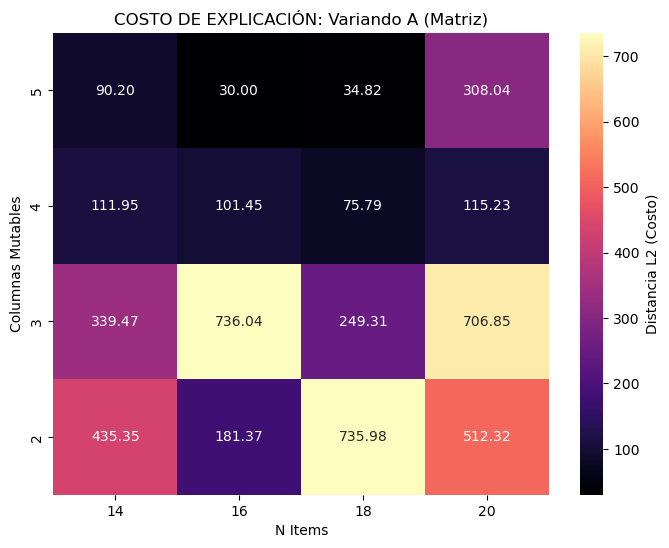

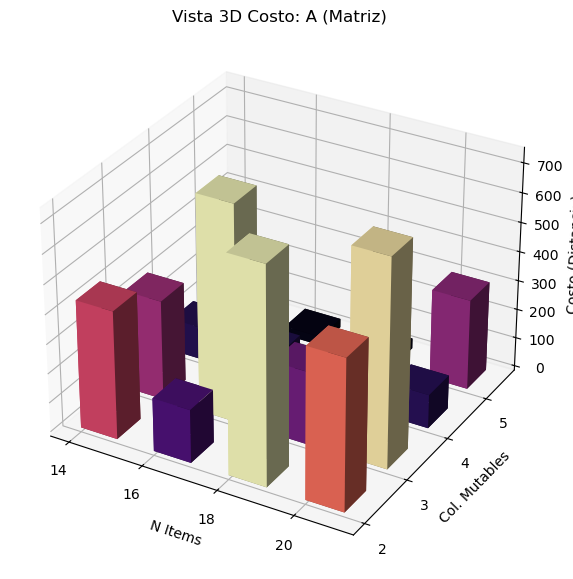

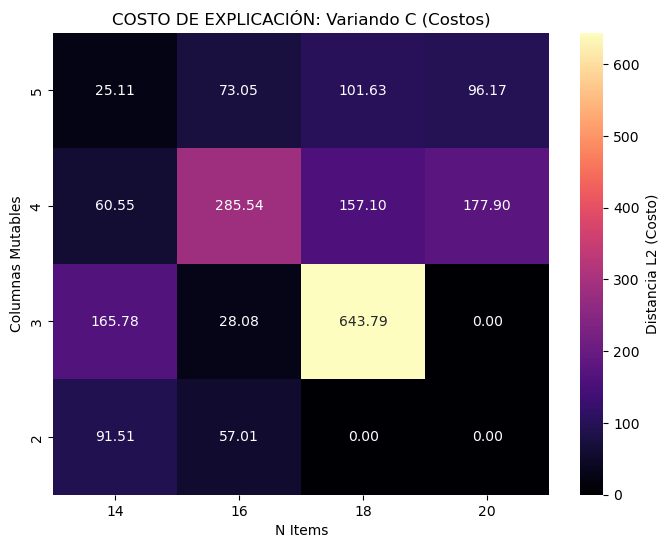

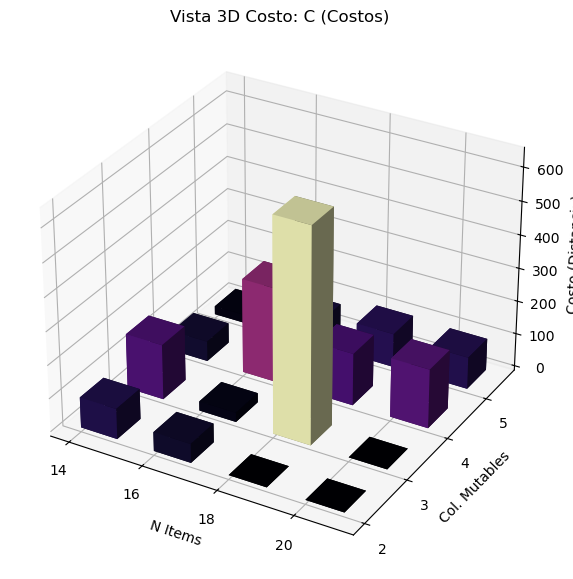

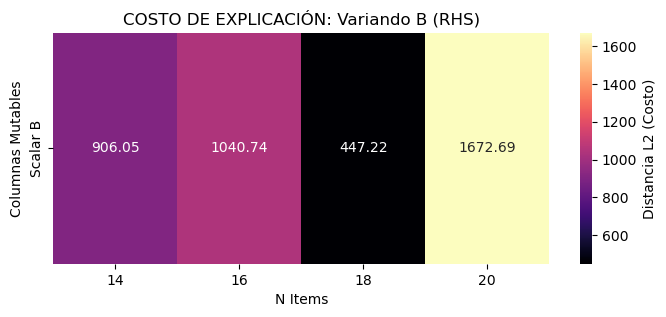

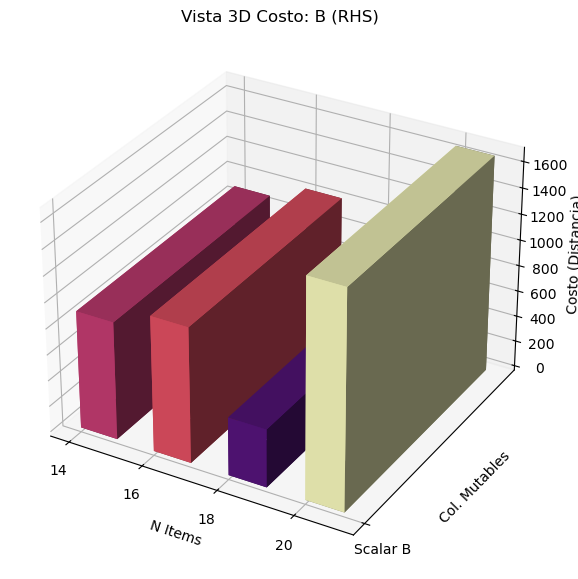

In [4]:
# =========================================================
# CELDA DE VISUALIZACIÓN ADICIONAL: FUNCIÓN OBJETIVO
# =========================================================

def plot_objective_analysis(obj_mat, mode_name, y_labels=None):
    if y_labels is None:
        y_labels = RANGES_MUTABLES
        
    rows, cols = obj_mat.shape
    
    # --- 1. Heatmap de Distancia ---
    plt.figure(figsize=(8, 6 if len(y_labels) > 1 else 3))
    annot_obj = np.empty_like(obj_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot_obj[i, j] = f"{obj_mat[i, j]:.2f}"
            
    # Usamos mapa de color 'magma' o 'inferno' para diferenciar de los tiempos
    sns.heatmap(obj_mat, annot=annot_obj, fmt="", cmap="magma", 
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, 
                cbar_kws={'label': 'Distancia L2 (Costo)'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables")
    plt.title(f"COSTO DE EXPLICACIÓN: Variando {mode_name}")
    plt.show()

    # --- 2. Gráfico 3D de Distancia ---
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    _x = np.arange(cols)
    _y = np.arange(rows)
    X_m, Y_m = np.meshgrid(_x, _y)
    
    x_flat = X_m.flatten()
    y_flat = Y_m.flatten()
    z_flat = np.zeros_like(x_flat)
    dx = 0.5 * np.ones_like(z_flat)
    dy = 0.5 * np.ones_like(z_flat)
    dz = obj_mat.flatten()
    
    from matplotlib import cm
    # Normalización segura para evitar errores si todos son 0
    max_val = max(np.max(dz), 0.001)
    norm = plt.Normalize(0, max_val)
    colors = cm.magma(norm(dz))
    
    ax.bar3d(x_flat, y_flat, z_flat, dx, dy, dz, color=colors, shade=True)
    
    ax.set_xticks(_x)
    ax.set_xticklabels(RANGES_N_ITEMS)
    ax.set_yticks(_y)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('N Items')
    ax.set_ylabel('Col. Mutables')
    ax.set_zlabel('Costo (Distancia)')
    plt.title(f"Vista 3D Costo: {mode_name}")
    plt.show()

# --- Generar los gráficos faltantes ---
print("Generando gráficos de Función Objetivo...")
plot_objective_analysis(obj_A, "A (Matriz)")
plot_objective_analysis(obj_C, "C (Costos)")
plot_objective_analysis(obj_B, "B (RHS)", y_labels=["Scalar B"])

### Variar todo (igual que antes, pero ahora bajo las mismas condiciones)


>>> Corriendo Experimento MIXTO (Varia A, C y B) <<<
[MIXTO] 1/16 | Mut=2, N=14 -> T=23.89s, Obj=213.88
[MIXTO] 2/16 | Mut=2, N=16 -> T=49.96s, Obj=270.01
[MIXTO] 3/16 | Mut=2, N=18 -> T=66.44s, Obj=218.75
[MIXTO] 4/16 | Mut=2, N=20 -> T=64.18s, Obj=395.82
[MIXTO] 5/16 | Mut=3, N=14 -> T=99.69s, Obj=544.99
[MIXTO] 6/16 | Mut=3, N=16 -> T=70.14s, Obj=69.04
[MIXTO] 7/16 | Mut=3, N=18 -> T=31.72s, Obj=51.18
[MIXTO] 8/16 | Mut=3, N=20 -> T=96.44s, Obj=15.89
[MIXTO] 9/16 | Mut=4, N=14 -> T=86.26s, Obj=89.36
[MIXTO] 10/16 | Mut=4, N=16 -> T=119.89s, Obj=74.50
[MIXTO] 11/16 | Mut=4, N=18 -> T=89.11s, Obj=67.34
[MIXTO] 12/16 | Mut=4, N=20 -> T=120.32s, Obj=0.00
[MIXTO] 13/16 | Mut=5, N=14 -> T=120.18s, Obj=0.00
[MIXTO] 14/16 | Mut=5, N=16 -> T=120.06s, Obj=0.00
[MIXTO] 15/16 | Mut=5, N=18 -> T=114.37s, Obj=8.43
[MIXTO] 16/16 | Mut=5, N=20 -> T=120.39s, Obj=0.00


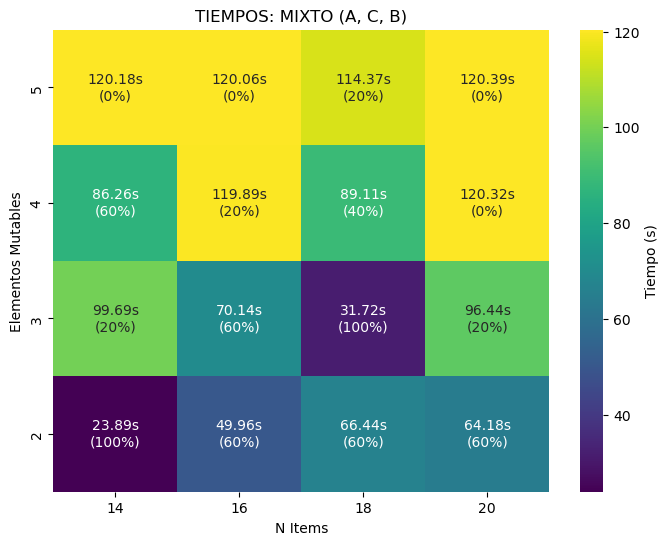

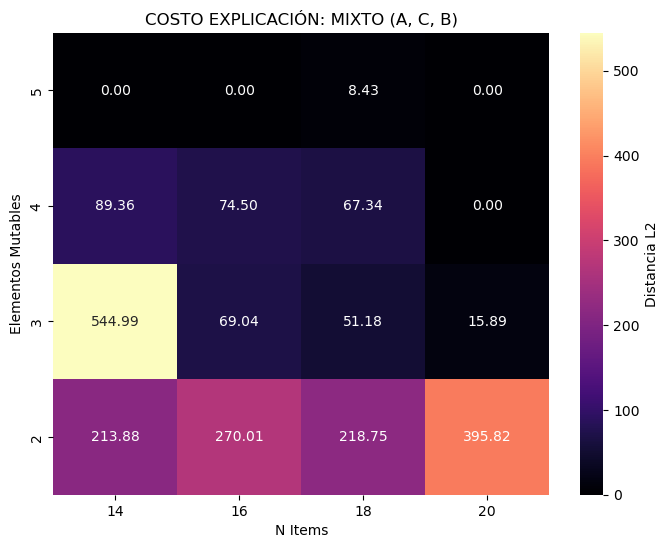

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP ROBUSTO (MIXTO: Varía A, C y B si se selecciona)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    n = len(c_hat)
    model = gp.Model("WCEP_Matrix_Mixed")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120 # Alineado con el otro código
    
    # --- VARIABLES (Límites alineados con código Flexible) ---
    c = model.addVars(n, lb=0.1, ub=1000.0, name="c") 
    a = model.addVars(n, lb=0.01, ub=50.0, name="a")
    
    max_physical_b = n * 50.0 # Alineado (antes era 10)
    b = model.addVar(lb=0.0, ub=max_physical_b, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    epsilon = 1e-5

    # --- INMUTABILIDAD ---
    # Índice n representa a 'b' en el pool de mutables
    b_is_mutable = (n in mutable_indices)
    
    if not b_is_mutable:
        model.addConstr(b >= b_hat - epsilon)
        model.addConstr(b <= b_hat + epsilon)
    else:
        # Si b es mutable, damos libertad (alineado con caso B)
        model.addConstr(b <= b_hat + 100)
        model.addConstr(b >= max(0, b_hat - 100))
    
    for j in range(n):
        if j not in mutable_indices:
            # Si la columna NO es mutable, fijamos tanto c como a
            model.addConstr(c[j] >= c_hat[j] - epsilon)
            model.addConstr(c[j] <= c_hat[j] + epsilon)
            model.addConstr(a[j] >= a_hat[j] - epsilon)
            model.addConstr(a[j] <= a_hat[j] + epsilon)
            
    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- OBJETIVO (Distancia L2) ---
    dist = 0
    for j in range(n):
        if j in mutable_indices:
            # En modo mixto, pagamos por cambiar c Y por cambiar a
            dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
    
    if b_is_mutable:
        dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    # RETORNO: (Factible?, ValorObjetivo)
    if model.Status == GRB.OPTIMAL:
        return True, model.ObjVal
    else:
        return False, None

# =========================================================
# 3. EXPERIMENTO: MIXTO (VARIANDO TODO)
# =========================================================
RANGES_N_ITEMS = [14, 16, 18, 20]
RANGES_MUTABLES = [2, 3, 4, 5]
REPEATS = 5

def run_experiment_mixed():
    print(f"\n>>> Corriendo Experimento MIXTO (Varia A, C y B) <<<")
    
    t_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    f_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS)))
    obj_mat = np.zeros((len(RANGES_MUTABLES), len(RANGES_N_ITEMS))) # Matriz para ObjVal
    
    total = len(RANGES_N_ITEMS) * len(RANGES_MUTABLES)
    count = 0
    
    for i, num_mutable in enumerate(RANGES_MUTABLES):
        for j, n_items in enumerate(RANGES_N_ITEMS):
            
            times, objs = [], []
            feas_count = 0
            
            # --- ALINEACIÓN: Target = 1 ---
            num_targets = 1 
            
            for r in range(REPEATS):
                seed = 4000 + (i*100) + (j*10) + r # Semilla distinta a los otros
                c_h, a_h, b_h = generate_data(n_items, seed)
                
                _, x_orig = solve_forward_standard(c_h, a_h, b_h)
                if x_orig is None: continue
                
                actives = [k for k, v in enumerate(x_orig) if v > 0.9]
                if not actives: continue
                
                # Target fijo (Elemento 0 de los activos)
                targets = [actives[0]] 
                
                # Pool de Mutables: indices 0..n-1 (columnas) y n (parametro b)
                pool_size = n_items + 1
                pool_candidates = list(range(pool_size))
                
                actual_k = min(num_mutable, pool_size)
                mutables = np.random.RandomState(seed).choice(pool_candidates, actual_k, replace=False)
                
                t0 = time.time()
                is_opt, obj_val = solve_wcep_matrix(c_h, a_h, b_h, targets, mutables)
                times.append(time.time() - t0)
                
                if is_opt: 
                    feas_count += 1
                    objs.append(obj_val)
                
            t_mat[i, j] = np.mean(times) if times else 0
            f_mat[i, j] = feas_count / REPEATS
            obj_mat[i, j] = np.mean(objs) if objs else 0
            
            count += 1
            print(f"[MIXTO] {count}/{total} | Mut={num_mutable}, N={n_items} -> T={t_mat[i,j]:.2f}s, Obj={obj_mat[i,j]:.2f}")

    return t_mat, f_mat, obj_mat

# --- Ejecución ---
time_M, feas_M, obj_M = run_experiment_mixed()

# =========================================================
# 4. PLOTTING MIXTO
# =========================================================
def plot_full_analysis(time_mat, feas_mat, obj_mat, mode_name, y_labels=None):
    if y_labels is None: y_labels = RANGES_MUTABLES
    rows, cols = time_mat.shape

    # 1. TIEMPOS
    plt.figure(figsize=(8, 6))
    annot = np.empty_like(time_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot[i, j] = f"{time_mat[i, j]:.2f}s\n({feas_mat[i, j]*100:.0f}%)"
    sns.heatmap(time_mat, annot=annot, fmt="", cmap="viridis",
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, cbar_kws={'label': 'Tiempo (s)'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Elementos Mutables")
    plt.title(f"TIEMPOS: {mode_name}")
    plt.show()

    # 2. DISTANCIA (COSTO)
    plt.figure(figsize=(8, 6))
    annot_obj = np.empty_like(obj_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot_obj[i, j] = f"{obj_mat[i, j]:.2f}"
    sns.heatmap(obj_mat, annot=annot_obj, fmt="", cmap="magma",
                xticklabels=RANGES_N_ITEMS, yticklabels=y_labels, cbar_kws={'label': 'Distancia L2'})
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Elementos Mutables")
    plt.title(f"COSTO EXPLICACIÓN: {mode_name}")
    plt.show()

plot_full_analysis(time_M, feas_M, obj_M, "MIXTO (A, C, B)")

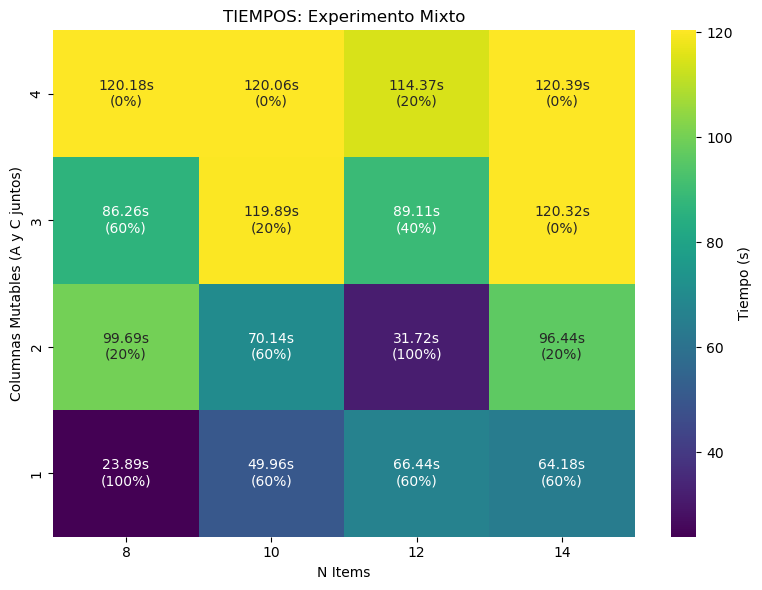

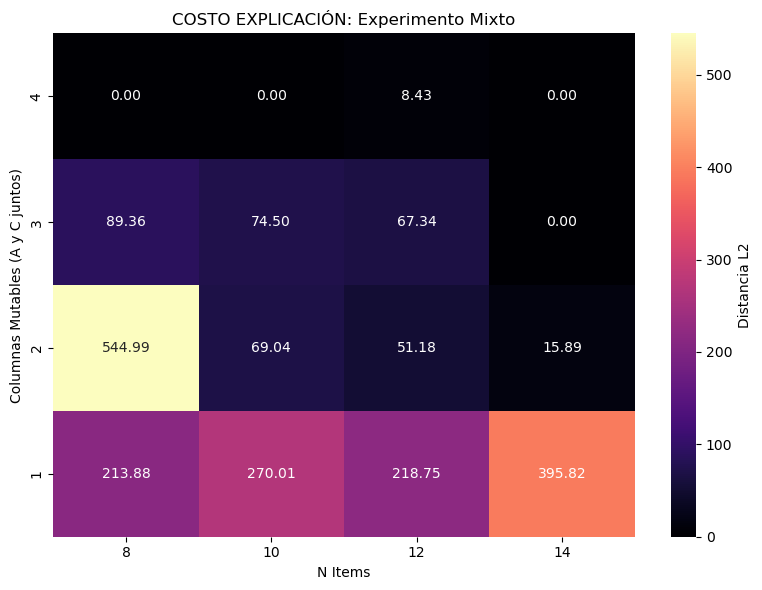

C:\Users\felip\AppData\Local\Temp\ipykernel_39532\92183353.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


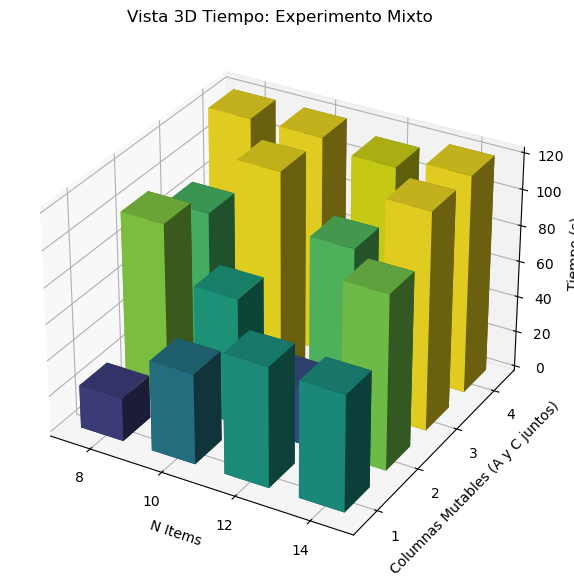

C:\Users\felip\AppData\Local\Temp\ipykernel_39532\92183353.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


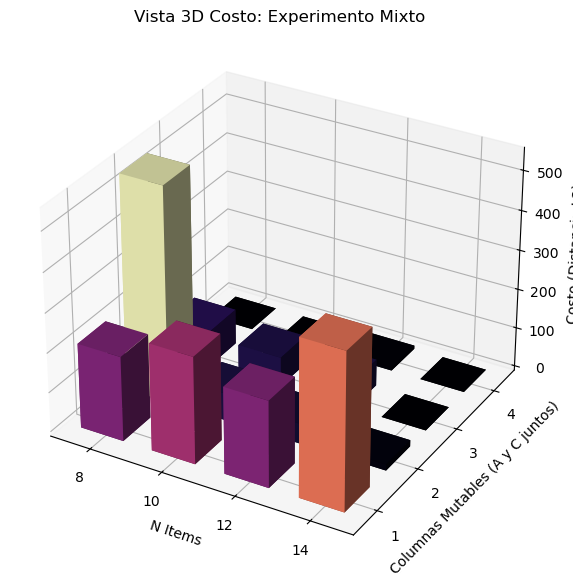

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

def _bar3d_from_matrix(mat, xlabels, ylabels, title, zlabel,
                       cmap_name="viridis", figsize=(10, 7)):
    """
    Dibuja un bar3d desde una matriz (rows = y, cols = x)
    """
    rows, cols = mat.shape

    # Grilla
    _x = np.arange(cols)
    _y = np.arange(rows)
    X, Y = np.meshgrid(_x, _y)

    x_flat = X.ravel()
    y_flat = Y.ravel()
    z_flat = np.zeros_like(x_flat, dtype=float)

    dx = 0.6 * np.ones_like(z_flat)
    dy = 0.6 * np.ones_like(z_flat)
    dz = mat.ravel().astype(float)

    # Colores por magnitud (evita max=0)
    max_val = float(np.nanmax(dz)) if np.isfinite(np.nanmax(dz)) else 1.0
    if max_val <= 0:
        max_val = 1.0
    norm = plt.Normalize(0, max_val)
    cmap = getattr(cm, cmap_name)
    colors = cmap(norm(np.clip(dz, 0, max_val)))

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x_flat, y_flat, z_flat, dx, dy, dz, color=colors, shade=True)

    ax.set_xticks(_x + dx[0]/2)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(_y + dy[0]/2)
    ax.set_yticklabels(ylabels)

    ax.set_xlabel("N Items")
    ax.set_ylabel("Columnas Mutables (A y C juntos)")
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


def plot_mixed_results(time_mat, feas_mat, obj_mat,
                       xlabels=None, ylabels=None):
    """
    time_mat: (rows, cols)
    feas_mat: (rows, cols) en [0,1]
    obj_mat : (rows, cols)
    """
    # Si no pasas labels, usa tus globals
    if xlabels is None:
        xlabels = RANGES_N_ITEMS
    if ylabels is None:
        ylabels = RANGES_MUTABLES

    rows, cols = time_mat.shape

    # --- 1. Heatmap TIEMPO ---
    plt.figure(figsize=(8, 6))
    annot_t = np.empty_like(time_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot_t[i, j] = f"{time_mat[i, j]:.2f}s\n({feas_mat[i, j]*100:.0f}%)"

    sns.heatmap(
        time_mat,
        annot=annot_t, fmt="",
        cmap="viridis",
        xticklabels=xlabels,
        yticklabels=ylabels,
        cbar_kws={'label': 'Tiempo (s)'}
    )
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables (A y C juntos)")
    plt.title("TIEMPOS: Experimento Mixto")
    plt.tight_layout()
    plt.show()

    # --- 2. Heatmap COSTO ---
    plt.figure(figsize=(8, 6))
    annot_obj = np.empty_like(obj_mat, dtype=object)
    for i in range(rows):
        for j in range(cols):
            annot_obj[i, j] = f"{obj_mat[i, j]:.2f}"

    sns.heatmap(
        obj_mat,
        annot=annot_obj, fmt="",
        cmap="magma",
        xticklabels=xlabels,
        yticklabels=ylabels,
        cbar_kws={'label': 'Distancia L2'}
    )
    plt.gca().invert_yaxis()
    plt.xlabel("N Items")
    plt.ylabel("Columnas Mutables (A y C juntos)")
    plt.title("COSTO EXPLICACIÓN: Experimento Mixto")
    plt.tight_layout()
    plt.show()

    # --- 3. 3D TIEMPO ---
    _bar3d_from_matrix(
        mat=time_mat,
        xlabels=xlabels,
        ylabels=ylabels,
        title="Vista 3D Tiempo: Experimento Mixto",
        zlabel="Tiempo (s)",
        cmap_name="viridis"
    )

    # --- 4. 3D COSTO ---
    _bar3d_from_matrix(
        mat=obj_mat,
        xlabels=xlabels,
        ylabels=ylabels,
        title="Vista 3D Costo: Experimento Mixto",
        zlabel="Costo (Distancia L2)",
        cmap_name="magma"
    )


# EJECUTAR
plot_mixed_results(time_M, feas_M, obj_M)
